# Project 2

This project is my first attempt at building a model to make predictions for a kaggle competition. This project will follow the general data science process, as we go through each step it will be labeled in the notebook below.

# Step 1: Define the Problem

The website Zillow wants to create a "market value" tool that will allow customers using their site to see an estimated price for any home they list on the site. This tool should be able to generalize to all houses within the city of Ames, Iowa. 

# Step 2: Gather data

Data was provided for this project, in the form of a .csv file. The csv file contained information on approximately 2,000 houses that were sold between 2005 and 2010 in Ames, with 80 features given for each sale.

# Step 3: Exploratory Data Analysis

Import necessary libraries

In [905]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression, Lasso, Ridge, LassoCV, RidgeCV, ElasticNetCV
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import mean_squared_error

%matplotlib inline

In [906]:
# Read in original data and save it to houses. Make a copy df that will be manipulated
houses = pd.read_csv('../Data/train.csv')
df = houses.copy()

# Read in test data and save it to houses_holdout. Make a copy test_data that will be manipulated
houses_holdout = pd.read_csv('../Data/test.csv')
test_data = houses_holdout.copy()

In [907]:
# Find number of rows and columns using df.shape
df.shape, test_data.shape

((2051, 81), (879, 80))

This data set has 2,051 rows, and 81 columns. Each row represents one house that was sold, while each column represents one feature, or one piece of information about the specific house that was sold

In [908]:
# Investigate first 5 rows using df.head()
df.head()

Id        PID  MS SubClass MS Zoning  Lot Frontage  Lot Area Street Alley  \
0  109  533352170           60        RL           NaN     13517   Pave   NaN   
1  544  531379050           60        RL          43.0     11492   Pave   NaN   
2  153  535304180           20        RL          68.0      7922   Pave   NaN   
3  318  916386060           60        RL          73.0      9802   Pave   NaN   
4  255  906425045           50        RL          82.0     14235   Pave   NaN   

  Lot Shape Land Contour    ...     Screen Porch Pool Area Pool QC Fence  \
0       IR1          Lvl    ...                0         0     NaN   NaN   
1       IR1          Lvl    ...                0         0     NaN   NaN   
2       Reg          Lvl    ...                0         0     NaN   NaN   
3       Reg          Lvl    ...                0         0     NaN   NaN   
4       IR1          Lvl    ...                0         0     NaN   NaN   

  Misc Feature Misc Val Mo Sold Yr Sold  Sale Type  SalePrice  
0          NaN        0       3    2010        WD      130500  
1          NaN        0       4    2009        WD      220000  
2          NaN        0       1    2010        WD      109000  
3          NaN        0       4    2010        WD      174000  
4          NaN        0       3    2010        WD      138500  

[5 rows x 81 columns]

Each row has an absolutely massive amount of information. Before moving forward, we need to determine what the data type of each column is, and how many null values are present in each column

In [909]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2051 entries, 0 to 2050
Data columns (total 81 columns):
Id                 2051 non-null int64
PID                2051 non-null int64
MS SubClass        2051 non-null int64
MS Zoning          2051 non-null object
Lot Frontage       1721 non-null float64
Lot Area           2051 non-null int64
Street             2051 non-null object
Alley              140 non-null object
Lot Shape          2051 non-null object
Land Contour       2051 non-null object
Utilities          2051 non-null object
Lot Config         2051 non-null object
Land Slope         2051 non-null object
Neighborhood       2051 non-null object
Condition 1        2051 non-null object
Condition 2        2051 non-null object
Bldg Type          2051 non-null object
House Style        2051 non-null object
Overall Qual       2051 non-null int64
Overall Cond       2051 non-null int64
Year Built         2051 non-null int64
Year Remod/Add     2051 non-null int64
Roof Style         20

There are a total of 11 columns stored as floats, 28 stored as integers, and 42 stored as objects. Before doing any modeling, all data that will be used in the model must be changed to numeric

In [910]:
df.describe()

Id           PID  MS SubClass  Lot Frontage       Lot Area  \
count  2051.000000  2.051000e+03  2051.000000   1721.000000    2051.000000   
mean   1474.033642  7.135900e+08    57.008776     69.055200   10065.208191   
std     843.980841  1.886918e+08    42.824223     23.260653    6742.488909   
min       1.000000  5.263011e+08    20.000000     21.000000    1300.000000   
25%     753.500000  5.284581e+08    20.000000     58.000000    7500.000000   
50%    1486.000000  5.354532e+08    50.000000     68.000000    9430.000000   
75%    2198.000000  9.071801e+08    70.000000     80.000000   11513.500000   
max    2930.000000  9.241520e+08   190.000000    313.000000  159000.000000   

       Overall Qual  Overall Cond   Year Built  Year Remod/Add  Mas Vnr Area  \
count   2051.000000   2051.000000  2051.000000     2051.000000   2029.000000   
mean       6.112140      5.562165  1971.708922     1984.190151     99.695909   
std        1.426271      1.104497    30.177889       21.036250    174.963129   
min        1.000000      1.000000  1872.000000     1950.000000      0.000000   
25%        5.000000      5.000000  1953.500000     1964.500000      0.000000   
50%        6.000000      5.000000  1974.000000     1993.000000      0.000000   
75%        7.000000      6.000000  2001.000000     2004.000000    161.000000   
max       10.000000      9.000000  2010.000000     2010.000000   1600.000000   

           ...        Wood Deck SF  Open Porch SF  Enclosed Porch  \
count      ...         2051.000000    2051.000000     2051.000000   
mean       ...           93.833740      47.556802       22.571916   
std        ...          128.549416      66.747241       59.845110   
min        ...            0.000000       0.000000        0.000000   
25%        ...            0.000000       0.000000        0.000000   
50%        ...            0.000000      27.000000        0.000000   
75%        ...          168.000000      70.000000        0.000000   
max        ...         1424.000000     547.000000      432.000000   

        3Ssn Porch  Screen Porch    Pool Area      Misc Val      Mo Sold  \
count  2051.000000   2051.000000  2051.000000   2051.000000  2051.000000   
mean      2.591419     16.511458     2.397855     51.574354     6.219893   
std      25.229615     57.374204    37.782570    573.393985     2.744736   
min       0.000000      0.000000     0.000000      0.000000     1.000000   
25%       0.000000      0.000000     0.000000      0.000000     4.000000   
50%       0.000000      0.000000     0.000000      0.000000     6.000000   
75%       0.000000      0.000000     0.000000      0.000000     8.000000   
max     508.000000    490.000000   800.000000  17000.000000    12.000000   

           Yr Sold      SalePrice  
count  2051.000000    2051.000000  
mean   2007.775719  181469.701609  
std       1.312014   79258.659352  
min    2006.000000   12789.000000  
25%    2007.000000  129825.000000  
50%    2008.000000  162500.000000  
75%    2009.000000  214000.000000  
max    2010.000000  611657.000000  

[8 rows x 39 columns]

Basic info for numeric columns

Investigate number of null values

In [911]:
df.isnull().sum()[df.isnull().sum() > 0].sort_values(ascending=False)

Pool QC           2042
Misc Feature      1986
Alley             1911
Fence             1651
Fireplace Qu      1000
Lot Frontage       330
Garage Yr Blt      114
Garage Cond        114
Garage Qual        114
Garage Finish      114
Garage Type        113
Bsmt Exposure       58
BsmtFin Type 2      56
Bsmt Cond           55
Bsmt Qual           55
BsmtFin Type 1      55
Mas Vnr Type        22
Mas Vnr Area        22
Bsmt Half Bath       2
Bsmt Full Bath       2
Garage Cars          1
BsmtFin SF 1         1
BsmtFin SF 2         1
Bsmt Unf SF          1
Garage Area          1
Total Bsmt SF        1
dtype: int64

In [912]:
test_data.isnull().sum()[test_data.isnull().sum() > 0].sort_values(ascending=False)

Pool QC           875
Misc Feature      838
Alley             821
Fence             707
Fireplace Qu      422
Lot Frontage      160
Garage Yr Blt      45
Garage Finish      45
Garage Qual        45
Garage Cond        45
Garage Type        44
BsmtFin Type 2     25
BsmtFin Type 1     25
Bsmt Exposure      25
Bsmt Cond          25
Bsmt Qual          25
Mas Vnr Area        1
Mas Vnr Type        1
Electrical          1
dtype: int64

In [913]:
df.drop(['Pool QC', 'Alley', 'Fence'], axis=1, inplace=True)
test_data.drop(['Pool QC', 'Alley', 'Fence'], axis=1, inplace=True)

## Data Cleaning

In [914]:
# Create function to find columns that contain a specific string
def col_finder(df, conditional_str):
    cols = [col for col in df.columns if conditional_str in col]
    return cols

def null_filler(df, col, value):
    df[col] = df[col].fillna(value)
    return None

There are multiple columns with many null values in both data sets. These columns will not have significant use, and should not be considered when making our model.
- Pool QC
- Alley
- Fence

The Misc Feature also can be eliminated from consideration as there is a column for the Misc Feature Value

Preprocessing

In [916]:
rating_dict = {'Ex':5, 'Gd': 4, 'TA': 3, 'Fa':2, 'Po':1, 'NA':0}

# Find all columns that use the rating system Ex, Gd, TA, Fa, Po
rating_cols = [col for col in df.columns if df[col].sort_values().iloc[0] == 'Ex']

# Remap using the dictionary created above
for col in rating_cols:
    df[col] = df[col].fillna('NA')
    df[col] = df[col].map(rating_dict)
    test_data[col] = test_data[col].fillna('NA')
    test_data[col] = test_data[col].map(rating_dict)

In [917]:
yes_no_dict = {'Y':1, 'N':0}
# Remap using the dictionary created above
df['Central Air'] = df['Central Air'].map(yes_no_dict)

test_data['Central Air'] = test_data['Central Air'].map(yes_no_dict)

In [918]:
houses['Central Air'] = houses['Central Air'].map(yes_no_dict)

houses_holdout['Central Air'] = houses_holdout['Central Air'].map(yes_no_dict)

In [919]:
# # This cell will create a dictionary to map values of categorical variables with fewer than 20 obesrvations to
# # 'Other' so that I have fewer columns when creating dummy varaibles with pd.get_dummies

# # sub_20_values = []
# # sub_20_cols = []
# # other_dict = {}
# # obj_cols = [col for col in df.columns if df[col].dtype == 'object']
# # for col in obj_cols:
# #     for value in df[col].unique():
# #         if type(value) == float:
# #             continue
# #         if df[col].value_counts()[value] < 20:
# #             sub_20_values.append([col, value, df[col].value_counts()[value]])
# #             sub_20_cols.append(col)
# #             if other_dict.get(col):
# #                 other_dict[col][value] = 'Other'
# #             else:
# #                 other_dict[col] = {value: 'Other'}
            

# len(sub_20_values)

# other_dict

# sub_20_cols = list(set(sub_20_cols))

In [920]:
dummies = ['Garage Finish', 'Garage Type', 'Bldg Type', 'BsmtFin Type 1', 'BsmtFin Type 2',
           'Exterior 1st', 'Exterior 2nd', 'Foundation', 'Heating', 'House Style', 'Land Contour', 'Land Slope',
           'Lot Config', 'Lot Shape', 'Mas Vnr Type', 'MS SubClass', 'MS Zoning', 'Neighborhood',
           'Roof Matl', 'Roof Style', 'Street', 'Utilities', 'Condition 1', 'Condition 2', 'Bsmt Exposure',
           'Electrical', 'Functional', 'Paved Drive', 'Sale Type', 'Mo Sold', 'Yr Sold']

In [921]:
for col in dummies:
    df[col] = df[col].fillna('NA')
    test_data[col] = test_data[col].fillna('NA')
    train_vals = sorted(df[col].unique().tolist())
    test_vals = sorted(test_data[col].unique().tolist())
    total_vals = set(train_vals + test_vals)
    df[col] = pd.Categorical(df[col], categories=total_vals)
    test_data[col] = pd.Categorical(test_data[col], categories=total_vals)

In [922]:
dummy_all = list(set(rating_cols + dummies))
dummy_all += ['Bsmt Qual', 'Fence', 'Alley', 'Pool QC']

for col in dummy_all:
    houses[col] = houses[col].fillna('NA')
    houses_holdout[col] = houses_holdout[col].fillna('NA')
    train_vals = sorted(houses[col].unique().tolist())
    test_vals = sorted(houses_holdout[col].unique().tolist())
    total_vals = set(train_vals + test_vals)
    houses[col] = pd.Categorical(houses[col], categories=total_vals)
    houses_holdout[col] = pd.Categorical(houses_holdout[col], categories=total_vals)

In [924]:
df = pd.get_dummies(df, columns=dummies, drop_first=True)
test_data = pd.get_dummies(test_data, columns=dummies, drop_first=True)

In [925]:
houses = pd.get_dummies(houses, columns=dummy_all, drop_first=True)
houses_holdout = pd.get_dummies(houses_holdout, columns=dummy_all, drop_first=True)

In [926]:
df.isnull().sum()[df.isnull().sum() > 0].sort_values(ascending=False)

Lot Frontage      330
Garage Yr Blt     114
Mas Vnr Area       22
Bsmt Half Bath      2
Bsmt Full Bath      2
Garage Area         1
Garage Cars         1
Total Bsmt SF       1
Bsmt Unf SF         1
BsmtFin SF 2        1
BsmtFin SF 1        1
dtype: int64

In [927]:
test_data.isnull().sum()[test_data.isnull().sum() > 0].sort_values(ascending=False)

Lot Frontage     160
Garage Yr Blt     45
Mas Vnr Area       1
dtype: int64

There are a substantial number of observations missing information for both Alley and Fence, so I will drop these features as they likely have little predictive power.

In [684]:
df.drop(['Alley', 'Fence'], axis=1, inplace=True)
test_data.drop(['Alley', 'Fence'], axis=1, inplace=True)

In [928]:
houses.isnull().sum()[houses.isnull().sum() > 0].sort_values(ascending=False)

Lot Frontage      330
Garage Yr Blt     114
Mas Vnr Area       22
Bsmt Half Bath      2
Bsmt Full Bath      2
Garage Area         1
Garage Cars         1
Total Bsmt SF       1
Bsmt Unf SF         1
BsmtFin SF 2        1
BsmtFin SF 1        1
dtype: int64

In [929]:
houses_holdout.isnull().sum()[houses_holdout.isnull().sum() > 0].sort_values(ascending=False)

Lot Frontage     160
Garage Yr Blt     45
Mas Vnr Area       1
dtype: int64

In [930]:
# Find which other columns are null for the one observation of null in BsmtFin SF 1
df[df['BsmtFin SF 1'].isnull()].isnull().sum()[df[df['BsmtFin SF 1'].isnull()].isnull().sum() > 0].sort_values(ascending=False)

Bsmt Half Bath    1
Bsmt Full Bath    1
Total Bsmt SF     1
Bsmt Unf SF       1
BsmtFin SF 2      1
BsmtFin SF 1      1
dtype: int64

This one row is missing most of the information for the basement. None of these columns also contain missing data in the test set, so these features do not require cleaning across all data. Because there is no way to infer the missing information from the given information, I will drop this observation from the dataset.

In [931]:
df.drop(labels=df[df['BsmtFin SF 1'].isnull()].index[0], axis=0, inplace=True)

In [947]:
houses.drop(labels=houses[houses['BsmtFin SF 1'].isnull()].index[0], axis=0, inplace=True)

In [932]:
df.shape

(2050, 261)

In [933]:
df.isnull().sum()[df.isnull().sum() > 0].sort_values(ascending=False)

Lot Frontage      330
Garage Yr Blt     114
Mas Vnr Area       22
Garage Area         1
Garage Cars         1
Bsmt Half Bath      1
Bsmt Full Bath      1
dtype: int64

In [934]:
df[df['Bsmt Full Bath'].isnull()].isnull().sum()[df[df['Bsmt Full Bath'].isnull()].isnull().sum() > 0].sort_values(ascending=False)

Bsmt Half Bath    1
Bsmt Full Bath    1
dtype: int64

Drop this observation again with same rationale as above

In [935]:
df.drop(labels = df[df['Bsmt Full Bath'].isnull()].index[0], axis=0, inplace=True)

houses.drop(labels = houses[houses['Bsmt Full Bath'].isnull()].index[0], axis=0, inplace=True)

In [936]:
df.isnull().sum()[df.isnull().sum() > 0].sort_values(ascending=False)

Lot Frontage     330
Garage Yr Blt    114
Mas Vnr Area      22
Garage Area        1
Garage Cars        1
dtype: int64

In [937]:
mas_cols = col_finder(df, 'Mas')
mas_cols

['Mas Vnr Area',
 'Mas Vnr Type_CBlock',
 'Mas Vnr Type_BrkFace',
 'Mas Vnr Type_BrkCmn',
 'Mas Vnr Type_None',
 'Mas Vnr Type_Stone']

In [938]:
NA_dummy_cols = col_finder(df, 'NA')
NA_dummy_cols

['Garage Finish_NA',
 'Garage Type_NA',
 'BsmtFin Type 1_NA',
 'BsmtFin Type 2_NA',
 'Neighborhood_NAmes',
 'Bsmt Exposure_NA',
 'Electrical_NA']

In [939]:
df[df['Mas Vnr Area'].isnull()][mas_cols]

Mas Vnr Area  Mas Vnr Type_CBlock  Mas Vnr Type_BrkFace  \
22             NaN                    0                     0   
41             NaN                    0                     0   
86             NaN                    0                     0   
212            NaN                    0                     0   
276            NaN                    0                     0   
338            NaN                    0                     0   
431            NaN                    0                     0   
451            NaN                    0                     0   
591            NaN                    0                     0   
844            NaN                    0                     0   
913            NaN                    0                     0   
939            NaN                    0                     0   
1025           NaN                    0                     0   
1244           NaN                    0                     0   
1306           NaN                    0                     0   
1430           NaN                    0                     0   
1434           NaN                    0                     0   
1606           NaN                    0                     0   
1699           NaN                    0                     0   
1815           NaN                    0                     0   
1820           NaN                    0                     0   
1941           NaN                    0                     0   

      Mas Vnr Type_BrkCmn  Mas Vnr Type_None  Mas Vnr Type_Stone  
22                      0                  0                   0  
41                      0                  0                   0  
86                      0                  0                   0  
212                     0                  0                   0  
276                     0                  0                   0  
338                     0                  0                   0  
431                     0                  0                   0  
451                     0                  0                   0  
591                     0                  0                   0  
844                     0                  0                   0  
913                     0                  0                   0  
939                     0                  0                   0  
1025                    0                  0                   0  
1244                    0                  0                   0  
1306                    0                  0                   0  
1430                    0                  0                   0  
1434                    0                  0                   0  
1606                    0                  0                   0  
1699                    0                  0                   0  
1815                    0                  0                   0  
1820                    0                  0                   0  
1941                    0                  0                   0

In [940]:
test_data[test_data['Mas Vnr Area'].isnull()][mas_cols]

Mas Vnr Area  Mas Vnr Type_CBlock  Mas Vnr Type_BrkFace  \
866           NaN                    0                     0   

     Mas Vnr Type_BrkCmn  Mas Vnr Type_None  Mas Vnr Type_Stone  
866                    0                  0                   0

All observations with null values for masonry also have null values for the masonry type. This implies that these houses do not have masonry. Therefore I will replace all null Mas Vnr Area values with 0

In [941]:
df['Mas Vnr Area'] = df['Mas Vnr Area'].fillna(0)
test_data['Mas Vnr Area'] = test_data['Mas Vnr Area'].fillna(0)

houses['Mas Vnr Area'] = houses['Mas Vnr Area'].fillna(0)
houses_holdout['Mas Vnr Area'] = houses_holdout['Mas Vnr Area'].fillna(0)

In [942]:
houses['Mas Vnr Area'] = houses['Mas Vnr Area'].fillna(0)
houses_holdout['Mas Vnr Area'] = houses_holdout['Mas Vnr Area'].fillna(0)

In [943]:
df.isnull().sum()[df.isnull().sum() > 0].sort_values(ascending=False)

Lot Frontage     330
Garage Yr Blt    114
Garage Area        1
Garage Cars        1
dtype: int64

In [944]:
test_data.isnull().sum()[test_data.isnull().sum() > 0].sort_values(ascending=False)

Lot Frontage     160
Garage Yr Blt     45
dtype: int64

In [949]:
houses.isnull().sum()[houses.isnull().sum() > 0].sort_values(ascending=False)

Lot Frontage     330
Garage Yr Blt    114
Garage Area        1
Garage Cars        1
dtype: int64

In [950]:
houses_holdout.isnull().sum()[houses_holdout.isnull().sum() > 0].sort_values(ascending=False)

Lot Frontage     160
Garage Yr Blt     45
dtype: int64

In [701]:
df[df['Garage Cars'].isnull()].isnull().sum().sort_values(ascending=False)

Garage Cars             1
Garage Area             1
Garage Yr Blt           1
Exterior 2nd_CBlock     0
Exterior 2nd_MetalSd    0
Exterior 2nd_CmentBd    0
Exterior 2nd_Brk Cmn    0
Exterior 2nd_Wd Shng    0
Exterior 1st_BrkComm    0
Exterior 1st_CemntBd    0
Exterior 1st_VinylSd    0
Exterior 1st_ImStucc    0
Exterior 1st_AsphShn    0
Exterior 1st_Stone      0
Exterior 1st_WdShing    0
Exterior 1st_Wd Sdng    0
Exterior 1st_HdBoard    0
Yr Sold_2010            0
Exterior 1st_PreCast    0
Exterior 1st_Plywood    0
Exterior 1st_AsbShng    0
Exterior 1st_CBlock     0
Exterior 1st_MetalSd    0
BsmtFin Type 2_ALQ      0
BsmtFin Type 2_BLQ      0
BsmtFin Type 2_Rec      0
BsmtFin Type 2_LwQ      0
BsmtFin Type 2_NA       0
BsmtFin Type 2_GLQ      0
BsmtFin Type 1_ALQ      0
                       ..
Neighborhood_BrkSide    0
Roof Matl_CompShg       0
Roof Matl_Tar&Grv       0
Roof Matl_WdShake       0
Roof Matl_Metal         0
Neighborhood_CollgCr    0
Neighborhood_Landmrk    0
Neighborhood

In [702]:
df[df['Garage Area'] == 0][col_finder(df,'Garage')].sum()

Garage Yr Blt            0.0
Garage Cars              0.0
Garage Area              0.0
Garage Qual              0.0
Garage Cond              0.0
Garage Finish_Unf        0.0
Garage Finish_NA       113.0
Garage Finish_RFn        0.0
Garage Type_NA         113.0
Garage Type_Detchd       0.0
Garage Type_Basment      0.0
Garage Type_BuiltIn      0.0
Garage Type_2Types       0.0
Garage Type_Attchd       0.0
dtype: float64

In [703]:
test_data[test_data['Garage Yr Blt'].isnull()][col_finder(test_data, 'Garage')].sum()

Garage Yr Blt            0.0
Garage Cars              1.0
Garage Area            360.0
Garage Qual              0.0
Garage Cond              0.0
Garage Finish_Unf        0.0
Garage Finish_NA        45.0
Garage Finish_RFn        0.0
Garage Type_NA          44.0
Garage Type_Detchd       1.0
Garage Type_Basment      0.0
Garage Type_BuiltIn      0.0
Garage Type_2Types       0.0
Garage Type_Attchd       0.0
dtype: float64

In the training data, all garages that have 0 area have 0 cars and have null values for the garage year built. This implies that the houses in these observations do not have garages. 

However, in the testing data there is one observation, index 765, where there is a garage with the house. This means that I have to replace the value for Garage Yr Blt for index 765 in the test data with a meaningful value. Since this value is impossible to know, there are a couple of options.
1. Use the year the house was built
2. Use the year of the last remodel on that house
3. The average value for Garage Yr Built from training data

In [704]:
garage_cols = col_finder(test_data, 'Garage')

In [705]:
test_data.loc[765, garage_cols]

Garage Yr Blt            NaN
Garage Cars              1.0
Garage Area            360.0
Garage Qual              0.0
Garage Cond              0.0
Garage Finish_Unf        0.0
Garage Finish_NA         1.0
Garage Finish_RFn        0.0
Garage Type_NA           0.0
Garage Type_Detchd       1.0
Garage Type_Basment      0.0
Garage Type_BuiltIn      0.0
Garage Type_2Types       0.0
Garage Type_Attchd       0.0
Name: 765, dtype: float64

In [706]:
df[df['Garage Area'].isnull()]

Id        PID  Lot Frontage  Lot Area  Overall Qual  Overall Cond  \
1712  2237  910201180          50.0      9060             5             6   

      Year Built  Year Remod/Add  Mas Vnr Area  Exter Qual      ...       \
1712        1923            1999           0.0           3      ...        

      Mo Sold_7  Mo Sold_8  Mo Sold_9  Mo Sold_10  Mo Sold_11  Mo Sold_12  \
1712          0          0          0           0           0           0   

      Yr Sold_2007  Yr Sold_2008  Yr Sold_2009  Yr Sold_2010  
1712             1             0             0             0  

[1 rows x 262 columns]

In [707]:
df.loc[1712, garage_cols]

Garage Yr Blt          NaN
Garage Cars            NaN
Garage Area            NaN
Garage Qual            0.0
Garage Cond            0.0
Garage Finish_Unf      0.0
Garage Finish_NA       1.0
Garage Finish_RFn      0.0
Garage Type_NA         0.0
Garage Type_Detchd     1.0
Garage Type_Basment    0.0
Garage Type_BuiltIn    0.0
Garage Type_2Types     0.0
Garage Type_Attchd     0.0
Name: 1712, dtype: float64

In [957]:
df.drop(1712, axis=0, inplace=True)

In [951]:
houses.drop(1712, axis=0, inplace=True)

In [952]:
df['Garage Yr Blt'].mean()

1978.7348837209302

In [953]:
test_data.loc[765, 'Garage Yr Blt'] = df['Garage Yr Blt'].mean()
houses_holdout.loc[765, 'Garage Yr Blt'] = houses['Garage Yr Blt'].mean()

In [711]:
min(df['Garage Yr Blt'].tolist())

1895.0

/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


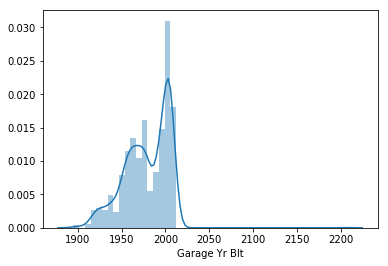

In [712]:
sns.distplot(df['Garage Yr Blt'][df['Garage Yr Blt'].notnull()])

In [968]:
np.corrcoef(df['Garage Yr Blt'][df['Garage Yr Blt'].notnull()], df['SalePrice'][df['Garage Yr Blt'].notnull()])

array([[1.        , 0.55051081],
       [0.55051081, 1.        ]])

In [967]:
temp = df['Garage Yr Blt'].fillna()
np.corrcoef(temp, df["SalePrice"])

array([[1.        , 0.55051081],
       [0.55051081, 1.        ]])

In [954]:
df['Garage Yr Blt'] = df['Garage Yr Blt'].fillna(1895)
test_data['Garage Yr Blt'] = test_data['Garage Yr Blt'].fillna(1895)

houses['Garage Yr Blt'] = houses['Garage Yr Blt'].fillna(1895)
houses_holdout['Garage Yr Blt'] = houses_holdout['Garage Yr Blt'].fillna(1895)

In [958]:
df.isnull().sum()[df.isnull().sum() > 0].sort_values(ascending=False)

Lot Frontage    330
dtype: int64

In [959]:
test_data.isnull().sum()[test_data.isnull().sum() > 0].sort_values(ascending=False)

Lot Frontage    160
dtype: int64

#### Predict Lot Frontage Values for missing info

In [960]:
target = 'Lot Frontage'
features = [col for col in df.columns if col != 'SalePrice' and col != target]

In [961]:
lot_holdout = df[df['Lot Frontage'].isnull()][features]
X_lot = df[df['Lot Frontage'].isnull() == False][features]
y_lot = df[df['Lot Frontage'].isnull() == False][target]

In [965]:
X_lot_train, X_lot_test, y_lot_train, y_lot_test = train_test_split(X_lot, y_lot, random_state=42, test_size=0.2)

ss_lot = StandardScaler()
X_lot_train_scaled = ss_lot.fit_transform(X_lot_train)
X_lot_test_scaled = ss_lot.transform(X_lot_test)

In [966]:
l1_ratios = np.linspace(0.1, 1.0, num=25)
e_net_lot = ElasticNetCV(l1_ratio=l1_ratios, cv=10, n_alphas=250, max_iter=2500)

e_net_scores = cross_val_score(e_net_lot, X_lot_train_scaled, y_lot_train, cv=10)
print('Elastic net cross-val scores:', e_net_scores.mean())

KeyboardInterrupt: 

In [ ]:
lasso_lot = LassoCV(n_alphas = 500, cv=10)

lasso_scores = cross_val_score(lasso_lot, X_lot_train_scaled, y_lot_train)
print('Lasso cross-val scores:', lasso_scores.mean())

In [ ]:
lasso_lot.fit(X_lot_train_scaled, y_lot_train)
lasso_lot.score(X_lot_test_scaled, y_lot_test)

In [ ]:
e_net_lot.fit(X_lot_train_scaled, y_lot_train)
e_net_lot.score(X_lot_test_scaled, y_lot_test)

In [ ]:
lot_holdout_scaled = ss_lot.transform(lot_holdout)

In [ ]:
lasso_lot_predictions = lasso_lot.predict(lot_holdout_scaled)
e_net_lot_predictions = e_net_lot.predict(lot_holdout_scaled)

In [727]:
for i in df.index:
    if df['Lot Frontage'].isnull()[i]:
        df.loc[i, 'Lot Frontage'] = lasso_lot_predictions[list(lot_holdout.index).index(i)]

In [728]:
test_lot = test_data[test_data['Lot Frontage'].isnull()][features]
test_lot_scaled = ss_lot.transform(test_lot)
lasso_holdout_predictions = lasso_lot.predict(test_lot_scaled)

for i in test_data.index:
    if test_data['Lot Frontage'].isnull()[i]:
        test_data.loc[i, 'Lot Frontage'] = lasso_holdout_predictions[list(test_lot.index).index(i)]

In [733]:
test_data.isnull().sum().sum() + df.isnull().sum().sum()

0

In [730]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2048 entries, 0 to 2050
Columns: 262 entries, Id to Yr Sold_2010
dtypes: float64(11), int64(36), uint8(215)
memory usage: 1.2 MB


In [731]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 879 entries, 0 to 878
Columns: 261 entries, Id to Yr Sold_2010
dtypes: float64(11), int64(35), uint8(215)
memory usage: 500.5 KB


Now there are no null values within the data. And all data is numeric

## Feature Engineering/Selection

Find which variables have the strongest correlation with Sale Price

In [732]:
df.corr().loc[:, 'SalePrice'].sort_values()

Garage Finish_Unf      -0.433129
Mas Vnr Type_None      -0.424512
Garage Type_Detchd     -0.369449
Foundation_CBlock      -0.356187
Bsmt Exposure_No       -0.293522
MS Zoning_RM           -0.280768
Paved Drive_N          -0.273915
PID                    -0.255293
Roof Style_Gable       -0.249497
MS SubClass_30         -0.248799
Garage Type_NA         -0.231243
Garage Finish_NA       -0.231243
Foundation_BrkTil      -0.230024
Sale Type_WD           -0.214881
Neighborhood_OldTown   -0.208617
Electrical_FuseA       -0.199599
House Style_1.5Fin     -0.196051
Exterior 1st_Wd Sdng   -0.191735
Neighborhood_IDOTRR    -0.189727
Neighborhood_NAmes     -0.189652
MS SubClass_50         -0.182567
Neighborhood_Edwards   -0.179408
Exterior 2nd_Wd Sdng   -0.173208
BsmtFin Type 1_NA      -0.160447
BsmtFin Type 2_NA      -0.155051
Bsmt Exposure_NA       -0.153122
BsmtFin Type 1_Rec     -0.151113
Exterior 1st_MetalSd   -0.148547
Exterior 2nd_MetalSd   -0.139558
Enclosed Porch         -0.135516
          

Find which variables have strong correlations with each other

In [736]:
mask = np.zeros_like(df.corr(), dtype=bool)
mask[np.triu_indices_from(mask)] = True
corr = df.corr()

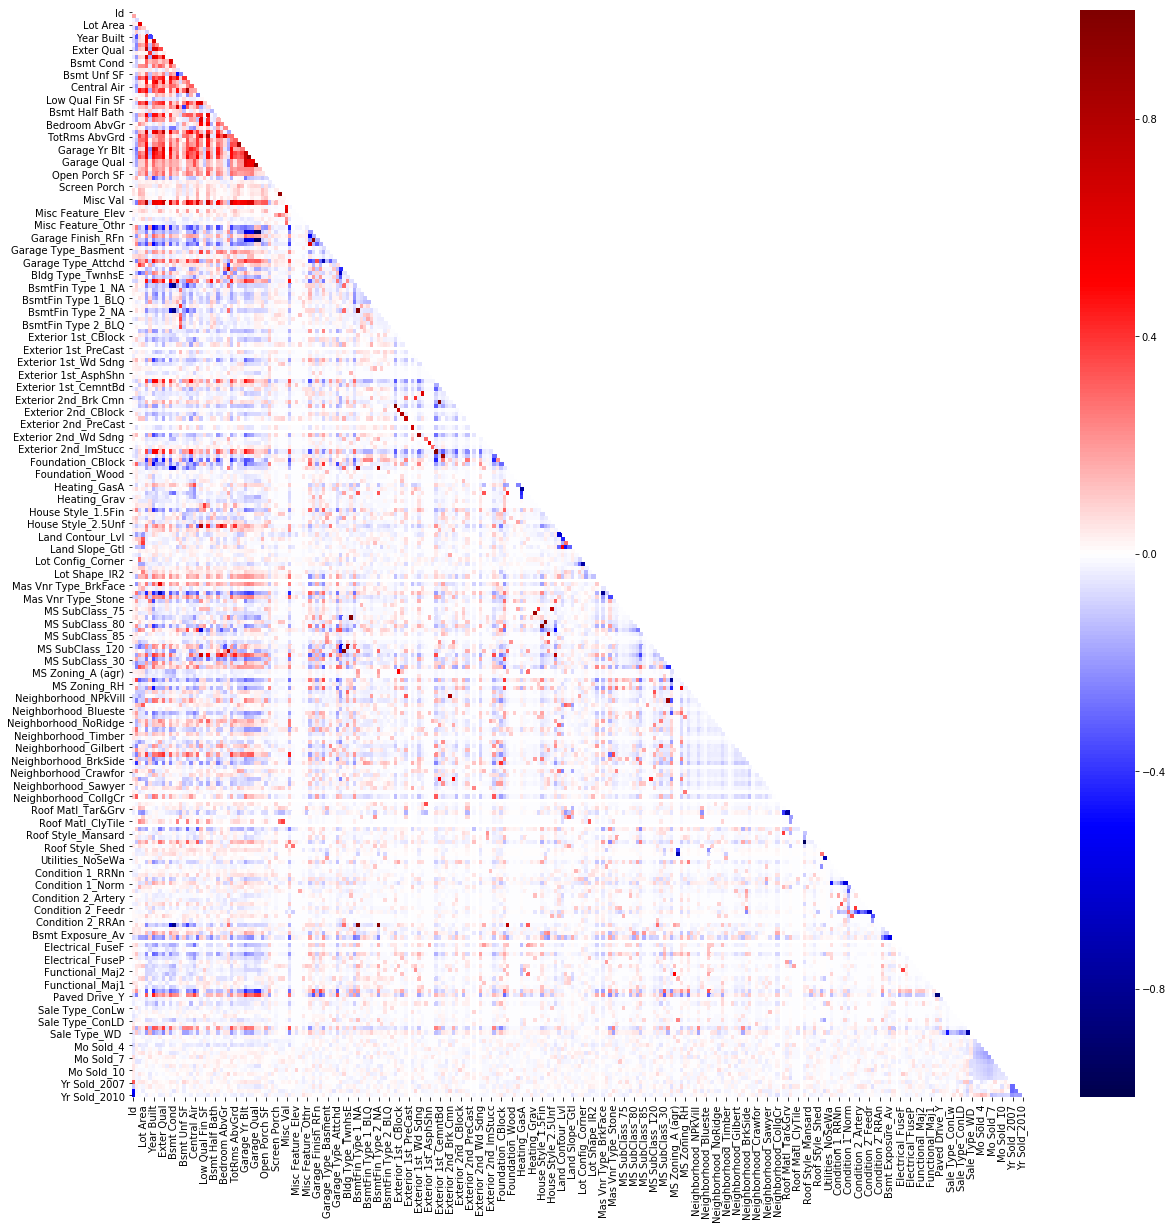

In [737]:
plt.figure(figsize=(20,20))
sns.heatmap(corr, mask=mask, cmap='seismic', vmin=-1, vmax=1)

In [738]:
strong_corr = {}
for i in range(corr.shape[0]):
    for j in range(i):
        if i == j:
            continue
        if corr.columns[i] in ['Id', 'PID'] or corr.columns[j] in ['Id', 'PID']:
            continue
        if abs(corr.iloc[i,j]) > 0.7:
            if strong_corr.get(corr.columns[i]):
                strong_corr[corr.columns[i]].append([corr.columns[j], corr.iloc[i,j]])
            else:
                strong_corr[corr.columns[i]] = [[corr.columns[j], corr.iloc[i,j]]]     

In [739]:
non_dummy_cols = [col for col in df.columns if '_' not in col]
non_dummies = df[non_dummy_cols]
non_dummies.head()

Id        PID  Lot Frontage  Lot Area  Overall Qual  Overall Cond  \
0  109  533352170     60.756654     13517             6             8   
1  544  531379050     43.000000     11492             7             5   
2  153  535304180     68.000000      7922             5             7   
3  318  916386060     73.000000      9802             5             5   
4  255  906425045     82.000000     14235             6             8   

   Year Built  Year Remod/Add  Mas Vnr Area  Exter Qual    ...      \
0        1976            2005         289.0           4    ...       
1        1996            1997         132.0           4    ...       
2        1953            2007           0.0           3    ...       
3        2006            2007           0.0           3    ...       
4        1900            1993           0.0           3    ...       

   Garage Cond  Wood Deck SF  Open Porch SF  Enclosed Porch  3Ssn Porch  \
0            3             0             44               0           0   
1            3             0             74               0           0   
2            3             0             52               0           0   
3            3           100              0               0           0   
4            3             0             59               0           0   

   Screen Porch  Pool Area  Pool QC  Misc Val  SalePrice  
0             0          0        0         0     130500  
1             0          0        0         0     220000  
2             0          0        0         0     109000  
3             0          0        0         0     174000  
4             0          0        0         0     138500  

[5 rows x 47 columns]

In [740]:
non_dummies.drop(['Id', 'PID'], axis=1, inplace=True)

/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3694: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [741]:
sns.pairplot(non_dummies)

In [ ]:
def all_strong_interactions (df1, target, df_list, strength=0.7):
    '''Find all second and third degree interaction features that have a correlation coefficient
    where |r| > strength. Ignores interactions features where all variables are dummy variables'''
    
    # Create count and progress dictionary to print progress checks
    count = 0 
    progress_dict = {289562: '10%', 579124: '20%', 868686: '30%', 1158248: '40%', 1447810: '50%',
                      1737372: '60%', 2026933: '70%', 2316496: '80%', 2606057: '90%'}
    # iterate through all possible combinations of features
    for r in range(2,4):
        for combo in itertools.combinations(df1.columns, r):
            # make list of column names and list of column series from dataframe
            col_names = list(combo)
            col_values = [df1[col] for col in col_names]
        
            # Check if all columns are dummies
            dummy_check = [df1[col].dtype for col in col_names]
            if len(dummy_check) == dummy_check.count('uint8'):
                continue
            
            
            interaction = reduce(lambda x,y: x*y, col_values)
            corr = np.corrcoef(interaction, target)[0][1]
            
            if abs(corr) > strength:
                df1['*'.join(col_names)] = interaction
                for frame in df_list:
                    frame_vals = [frame[col] for col in col_names]
                    frame_interaction = reduce(lambda x,y: x*y, frame_vals)
                    frame['*'.join(col_names)] = frame_interaction
            count += 1
            if count in list(progress_dict.keys):
                print(progress_dict[count])
        print(r)
    return None

In [877]:
si_feats = [col for col in df.columns if col not in ['SalePrice', 'Id', 'PID']]
X_si = df[si_feats]
y_si = df['SalePrice']

X_si_hold = test_data[si_feats]

X_si_train, X_si_test, y_si_train, y_si_test = train_test_split(X_si, y_si, test_size=0.2, random_state=8)

In [878]:
all_strong_interactions(X_si_train, y_si_train, [X_si_test, X_si_hold])

/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:3183: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:3184: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


2
10%


KeyboardInterrupt: 

In [851]:
import itertools
from functools import reduce

#  reduce(lambda x, y: x*y, [1,2,3,4,5,6])

def best_interaction_finder (df1, str_list, target, df_list):
    cols = []
    for feat in str_list:
        cols.extend(col_finder(df1, feat))
    cols = [a for a in cols if '*' not in a]
    best_r2 = 0
    feature_combo = None
    series = None
    if len(cols) < 2:
        print('Only {} columns found'.format(len(cols)))
        return None
    if len(cols) == 2:
        print('Only 2 colums found. Only returning Interaction and R2 score, not adding to DF')
        corr = np.corrcoef(df1[cols[0]]*df1[cols[1]], target)[0][1]
        name = '*'.join(cols)
        return (corr, name)
    max_combo_size= min([len(cols), 5])
    for r in range(2, max_combo_size):
        for combo in itertools.combinations(cols, r):
            temp = [df1[item] for item in list(combo)]
            interaction = reduce(lambda x, y: x*y, temp)
            corr = np.corrcoef(interaction, target)[0][1]
            if abs(corr) > best_r2:
                best_r2 = abs(corr)
                feature_combo = list(combo)
                series = interaction
    df1['*'.join(feature_combo)] = series
    for frame in df_list:
        temp_frame = [frame[item] for item in feature_combo]
        temp_interact = reduce(lambda x, y: x*y, temp_frame)
        frame['*'.join(feature_combo)] = temp_interact
    return (best_r2, '*'.join(feature_combo))

In [852]:
test_int_feat = [col for col in test_data.columns if col !='Id' and col !='PID']
test_data_inter = test_data.copy()[test_int_feat]
test_data_inter.head()

Lot Frontage  Lot Area  Overall Qual  Overall Cond  Year Built  \
0     69.000000      9142             6             8        1910   
1     73.430260      9662             5             4        1977   
2     58.000000     17104             7             5        2006   
3     60.000000      8520             5             6        1923   
4     77.783584      9500             6             5        1963   

   Year Remod/Add  Mas Vnr Area  Exter Qual  Exter Cond  Bsmt Qual  \
0            1950           0.0           3           2          2   
1            1977           0.0           3           3          4   
2            2006           0.0           4           3          4   
3            2006           0.0           4           3          3   
4            1963         247.0           3           3          4   

       ...       Mo Sold_7  Mo Sold_8  Mo Sold_9  Mo Sold_10  Mo Sold_11  \
0      ...               0          0          0           0           0   
1      ...               0          1          0           0           0   
2      ...               0          0          1           0           0   
3      ...               1          0          0           0           0   
4      ...               1          0          0           0           0   

   Mo Sold_12  Yr Sold_2007  Yr Sold_2008  Yr Sold_2009  Yr Sold_2010  
0           0             0             0             0             0  
1           0             0             0             0             0  
2           0             0             0             0             0  
3           0             1             0             0             0  
4           0             0             0             1             0  

[5 rows x 259 columns]

In [853]:
int_feat = [col for col in df.columns if col != 'Id' and col != 'PID']
X_inter = df[int_feat]
y = df['SalePrice']

X_inter_train, X_inter_test, y_int_train, y_int_test = train_test_split(X_inter, y, test_size=0.2)

In [854]:
best_interaction_finder(X_inter_train, ['Qual'], y_int_train, [X_inter_test, test_data_inter])

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


(0.8468291356553741, 'Overall Qual*Bsmt Qual*Kitchen Qual*Garage Qual')

In [855]:
best_interaction_finder(X_inter_train, ['Garage'], y_int_train, [X_inter_test, test_data_inter])

/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:3183: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:3184: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


(0.7111751651292226, 'Garage Yr Blt*Garage Cars*Garage Area*Garage Qual')

In [856]:
best_interaction_finder(X_inter_train, ['Area'], y_int_train, [X_inter_test, test_data_inter])

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


(0.7389621194651423, 'Gr Liv Area*Garage Area')

In [857]:
best_interaction_finder(X_inter_train, ['Bsmt'], y_int_train, [X_inter_test, test_data_inter])

/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:3183: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:3184: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


(0.727733823354396, 'Bsmt Qual*Total Bsmt SF')

In [858]:
best_interaction_finder(X_inter_train, ['SF'], y_int_train, [X_inter_test, test_data_inter])

/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:3183: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:3184: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


(0.4981834194380735, 'Total Bsmt SF*1st Flr SF')

In [859]:
best_interaction_finder(X_inter_train, ['Garage', 'Qual'], y_int_train, [X_inter_test, test_data_inter])

/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:3183: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:3184: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


(0.86757208853931, 'Garage Cars*Overall Qual*Bsmt Qual*Kitchen Qual')

In [ ]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
ax1.plot(x, y)
ax1.set_title('Sharing Y axis')
ax2.scatter(x, y)

In [ ]:
plt.subplot(2, 1, 1)
plt.plot(x1, y1, 'o-')
plt.title('A tale of 2 subplots')
plt.ylabel('Damped oscillation')

plt.subplot(2, 1, 2)
plt.plot(x2, y2, '.-')
plt.xlabel('time (s)')
plt.ylabel('Undamped')

Text(0.5,1,'Basement Area r =0.632')

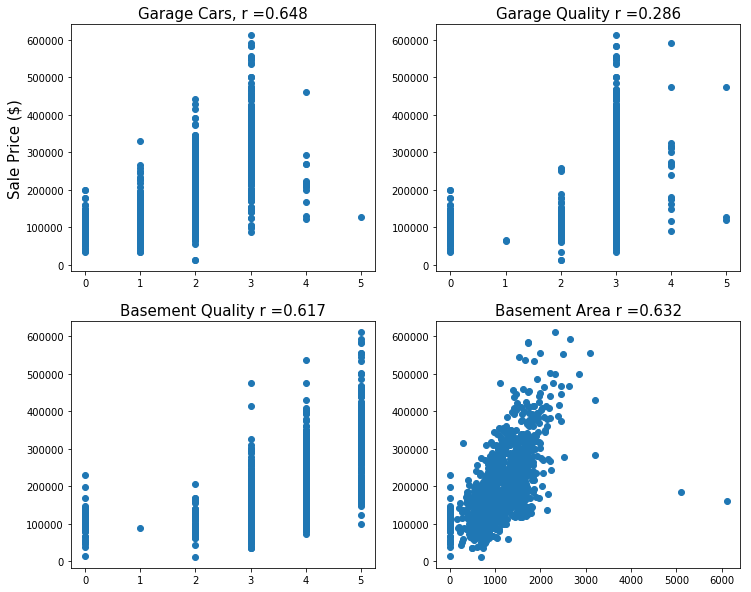

In [1030]:
plt.figure(figsize=(12,10))
plt.tight_layout()
plt.title('Individual Features')

plt.subplot(2, 2, 1)
plt.scatter(df['Garage Cars'], df['SalePrice'])
plt.title('Garage Cars, r ={}'.format(round(np.corrcoef(df['Garage Cars'], df['SalePrice'])[0][1], 3)), size=15)
plt.ylabel('Sale Price ($)', size = 15)

plt.subplot(2,2,2)
plt.scatter(df['Garage Qual'], df['SalePrice'])
plt.title('Garage Quality r ={}'.format(round(np.corrcoef(df['Garage Qual'], df['SalePrice'])[0][1], 3)),
         size=15)

plt.subplot(2,2,3)
plt.scatter(df['Bsmt Qual'], df['SalePrice'])
plt.title('Basement Quality r ={}'.format(round(np.corrcoef(df['Bsmt Qual'], df['SalePrice'])[0][1], 3)), size=15)

plt.subplot(2,2,4)
plt.scatter(df['Total Bsmt SF'], df['SalePrice'])
plt.title('Basement Area r ={}'.format(round(np.corrcoef(df['Total Bsmt SF'], df['SalePrice'])[0][1], 3)),size=15)

Text(0,1,'Sale Price ($)')

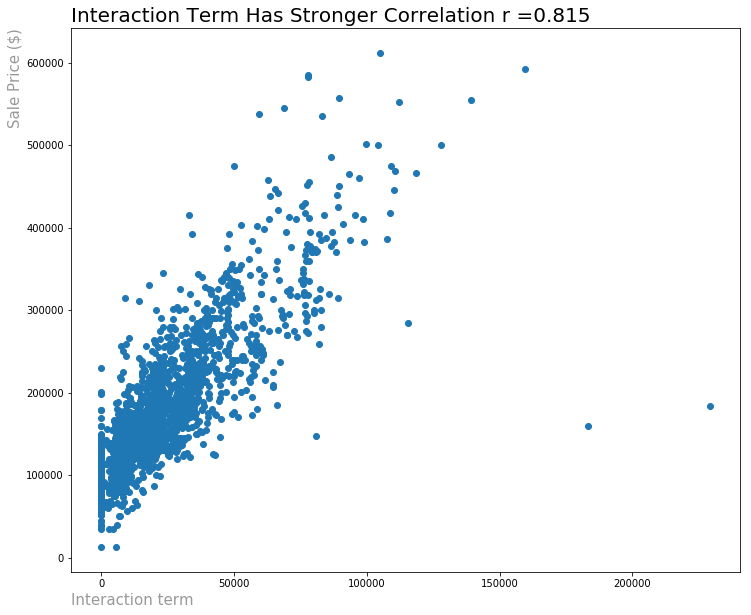

In [1031]:
plt.figure(figsize=(12,10))
plt.scatter(df['Garage Cars']*df['Garage Qual']* df['Bsmt Qual']*df['Total Bsmt SF'], df['SalePrice'])
plt.title('Interaction Term Has Stronger Correlation r ={}'.format(
          round(np.corrcoef(df['Garage Cars']*df['Garage Qual']* df['Bsmt Qual']*df['Total Bsmt SF'], df['SalePrice'])[0][1], 3)),
          size=20, position=(0,1), ha='left')
plt.xlabel('Interaction term', position=(0,0), size=15, alpha=0.4, ha='left')
plt.ylabel('Sale Price ($)', position=(0,1), size=15, alpha=0.4, ha='right')

In [860]:
best_interaction_finder(X_inter_train, ['Garage', 'Bsmt'], y_int_train, [X_inter_test, test_data_inter])

/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:3183: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:3184: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


(0.8044756398745313, 'Garage Cars*Garage Qual*Bsmt Qual*Total Bsmt SF')

In [861]:
best_interaction_finder(X_inter_train, ['Type'], y_int_train, [X_inter_test, test_data_inter])

/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:3183: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:3184: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


(0.46533343333137867, 'Bldg Type_1Fam*BsmtFin Type 1_GLQ')

In [862]:
best_interaction_finder(X_inter_train, ['Lot'], y_int_train, [X_inter_test, test_data_inter])

/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:3183: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:3184: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


(0.31656936673578107, 'Lot Area*Lot Shape_IR1')

In [864]:
best_interaction_finder(X_inter_train, ['Porch', 'Deck'], y_int_train, [X_inter_test, test_data_inter])

/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:3183: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:3184: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


(0.33844051832877525, 'Open Porch SF*Wood Deck SF')

In [787]:
X_inter_train.drop('SalePrice', axis=1, inplace=True)
X_inter_test.drop('SalePrice', axis=1, inplace=True)

/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3694: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [788]:
set1, set2 = set(X_inter_train.columns), set(test_data_inter.columns)
set2.difference(set1)

set()

In [790]:
test_lr = LinearRegression()

inter_scores = cross_val_score(test_lr, X_inter_train, y_int_train, cv=10)
print(inter_scores)
print(inter_scores.mean())

[0.94451841 0.31634426 0.90821016 0.04845605 0.92088447 0.90178918
 0.88831342 0.92276574 0.87791653 0.8879595 ]
0.7617157729221296


In [792]:
test_lr.fit(X_inter_train, y_int_train)
test_lr.score(X_inter_test, y_int_test)

0.9422670783411184

In [799]:
X_inter_tot = pd.concat([X_inter_train, X_inter_test], axis=0)
X_inter_tot.sort_index(inplace=True)

In [800]:
test_lr.score(X_inter_tot, y)

0.9462440663514416

In [804]:
inter_preds = test_lr.predict(test_data_inter)

submission = pd.DataFrame(data = inter_preds, index = test_data['Id'])
submission.rename({0: "SalePrice"}, axis=1, inplace=True)
submission.head()
submission.to_csv('../Data/submission.csv')

In [806]:
ss_inter = StandardScaler()

ss_inter.fit(X_inter_train)
X_inter_train_scaled = ss_inter.transform(X_inter_train)
X_inter_test_scaled = ss_inter.transform(X_inter_test)

lasso_inter = LassoCV(n_alphas=5000, cv = 10, verbose=1)

inter_lasso_scores = cross_val_score(lasso_inter, X_inter_train_scaled, y_int_train, cv=10)
print(inter_lasso_scores)
print(inter_lasso_scores.mean())

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

[0.93796229 0.68198196 0.91763757 0.55413401 0.9207894  0.90337707
 0.924349   0.90790424 0.90288275 0.87987599]
0.8530894269943421


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   25.5s finished


In [807]:
lasso_inter.fit(X_inter_train_scaled, y_int_train)
lasso_inter.score(X_inter_test_scaled, y_int_test)

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

......................................................................................................................................................................................................................[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   28.0s finished


0.9382427317373258

In [810]:
test_data_inter_scaled = ss_inter.transform(test_data_inter)
lasso_inter_preds = lasso_inter.predict(test_data_inter_scaled)
submission = pd.DataFrame(data = lasso_inter_preds, index = test_data['Id'])
submission.rename({0: "SalePrice"}, axis=1, inplace=True)
submission.head()
submission.to_csv('../Data/submission.csv')

In [447]:
def best_degree_2_interactions(df1, target, num, df2):
    interactions = []
    correlations = []
    for col in df1.columns:
        for col2 in df1.columns:
            corr = np.corrcoef(df1[col] * df1[col2], target)[0][1]
            if correlations == []:
                correlations.append(corr)
                interactions.append([col, col2])
            if abs(corr) > min(correlations):
                temp = [min([col, col2]), max([col, col2])]
                if temp in interactions:
                    continue
                correlations.append(abs(corr))
                interactions.append(temp)
                if len(correlations) > num:
                    del interactions[correlations.index(min(correlations))]
                    correlations.remove(min(correlations))
    for item in interactions:
        name = "*".join(item)
        df1[name] = df1[item[0]]*df1[item[1]]
        df2[name] = df2[item[0]]*df2[item[1]]
    return None
    

In [448]:
df.shape

(2048, 249)

In [453]:
ft = [col for col in df.columns if col != 'SalePrice']
T = df[ft]
T2 = test_data.copy()
y = df['SalePrice']

In [454]:
T.shape, T2.shape

((2048, 248), (879, 248))

In [455]:
best_degree_2_interactions(T, df['SalePrice'], 500, T2)

/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:3183: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:3184: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


In [456]:
T.shape, T2.shape

((2048, 748), (879, 748))

In [474]:
XT_train, XT_test, yT_train, yT_test = train_test_split(T, y, test_size=0.2)

In [475]:
linreg = LinearRegression()

scores = cross_val_score(linreg, XT_train, yT_train, cv=5)
print(scores)
print(scores.mean())

[0.86511477 0.82779247 0.76763356 0.65078605 0.77587409]
0.7774401876061164


In [476]:
linreg.fit(XT_train, yT_train)
linreg.score(XT_test, yT_test)

0.8469503397014243

In [249]:
test_lr = LinearRegression()

inter_scores = cross_val_score(test_lr, X_inter_train, y_train)
print(inter_scores)
print(inter_scores.mean())

[0.81357404 0.88880053 0.47957253]
0.7273156975109676


In [250]:
test_lr.fit(X_inter_train, y_train)
test_lr.score(X_inter_test, y_test)

0.8149750605349466

In [199]:
best_interaction_finder(df, ['Area', 'SF'], 'SalePrice')

['Lot Area', 'Mas Vnr Area', 'Gr Liv Area', 'Garage Area', 'Pool Area', 'BsmtFin SF 1', 'BsmtFin SF 2', 'Bsmt Unf SF', 'Total Bsmt SF', '1st Flr SF', '2nd Flr SF', 'Low Qual Fin SF', 'Wood Deck SF', 'Open Porch SF']


/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:3183: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:3184: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


(0.7642073054778854, ['Gr Liv Area', 'Garage Area'])

In [202]:
best_interaction_finder(df, ['Qual', 'Garage'], 'SalePrice')

['Overall Qual', 'Exter Qual', 'Bsmt Qual', 'Low Qual Fin SF', 'Kitchen Qual', 'Garage Qual', 'Garage Yr Blt', 'Garage Cars', 'Garage Area', 'Garage Qual', 'Garage Cond']
Overall Qual*Bsmt Qual*Kitchen Qual*Garage Qual*Garage Cars


(0.872562886901016,
 ['Overall Qual', 'Bsmt Qual', 'Kitchen Qual', 'Garage Qual', 'Garage Cars'])

In [182]:
best_interaction_finder(df, 'Qual', 'SalePrice')

['Overall Qual', 'Exter Qual', 'Bsmt Qual', 'Low Qual Fin SF', 'Kitchen Qual', 'Garage Qual']


(0.8478821111230697,
 ['Overall Qual', 'Exter Qual', 'Bsmt Qual', 'Kitchen Qual', 'Garage Qual'])

In [183]:
best_interaction_finder(df, 'Garage', 'SalePrice')

['Garage Yr Blt', 'Garage Cars', 'Garage Area', 'Garage Qual', 'Garage Cond']


(0.7196479023313134,
 ['Garage Yr Blt', 'Garage Cars', 'Garage Area', 'Garage Qual'])

In [184]:
best_interaction_finder(df, 'SF', 'SalePrice')

['BsmtFin SF 1', 'BsmtFin SF 2', 'Bsmt Unf SF', 'Total Bsmt SF', '1st Flr SF', '2nd Flr SF', 'Low Qual Fin SF', 'Wood Deck SF', 'Open Porch SF']


/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:3183: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:3184: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


(0.5404143183111503, ['Total Bsmt SF', '1st Flr SF'])

In [185]:
best_interaction_finder(df, 'Bsmt', 'SalePrice')

['Bsmt Qual', 'Bsmt Cond', 'BsmtFin SF 1', 'BsmtFin SF 2', 'Bsmt Unf SF', 'Total Bsmt SF', 'Bsmt Full Bath', 'Bsmt Half Bath']


(0.7454844557051902, ['Bsmt Qual', 'Bsmt Cond', 'Total Bsmt SF'])

In [187]:
df.iloc[[1885, 960], :][col_finder(df, 'SF') + col_finder(df, 'Area')]

BsmtFin SF 1  BsmtFin SF 2  Bsmt Unf SF  Total Bsmt SF  1st Flr SF  \
1888         566.0           0.0        289.0          855.0         855   
961          619.0           0.0        149.0          768.0         768   

      2nd Flr SF  Low Qual Fin SF  Wood Deck SF  Open Porch SF  \
1888         601                0            87              0   
961            0                0           104              0   

      House Style_SFoyer  Lot Area  Mas Vnr Area  Gr Liv Area   Garage Area  \
1888                   0      2280           0.0         1456  3.394795e+12   
961                    1      7244           0.0          768  4.895287e+12   

      Pool Area  
1888          0  
961           0

In [124]:
df['1st Flr SF'].sort_values(ascending=False)

1885    5095
960     4692
328     3228
1243    2898
952     2726
1227    2696
1117    2633
30      2524
913     2515
786     2497
623     2492
685     2490
1058    2464
1647    2452
1164    2402
199     2392
1523    2365
1671    2364
1964    2338
800     2290
1158    2276
980     2259
81      2234
480     2234
378     2223
1248    2217
1934    2200
949     2196
1198    2158
2028    2156
        ... 
1772     525
1431     525
796      525
1834     525
77       520
1468     520
269      520
1051     520
1040     520
1707     502
1292     498
146      495
1274     494
1643     492
1552     483
395      483
1294     483
906      483
910      483
179      483
10       483
342      483
135      483
2006     483
1518     480
252      453
217      448
432      438
700      372
1428     334
Name: 1st Flr SF, Length: 2048, dtype: int64

In [122]:
df['Garage Yr Blt'].sort_values(ascending=False)[1699]

2207.0

In [123]:
df.iloc[1699, :]

Id                      2687.0
PID                903425190.0
Lot Frontage              90.0
Lot Area               33120.0
Overall Qual               6.0
Overall Cond               5.0
Year Built              1962.0
Year Remod/Add          1962.0
Mas Vnr Area               0.0
Exter Qual                 3.0
Exter Cond                 3.0
Bsmt Qual                  3.0
Bsmt Cond                  3.0
BsmtFin SF 1               0.0
BsmtFin SF 2               0.0
Bsmt Unf SF             1595.0
Total Bsmt SF           1595.0
Heating QC                 3.0
Central Air                1.0
1st Flr SF              1611.0
2nd Flr SF               875.0
Low Qual Fin SF            0.0
Gr Liv Area             2486.0
Bsmt Full Bath             0.0
Bsmt Half Bath             0.0
Full Bath                  2.0
Half Bath                  0.0
Bedroom AbvGr              5.0
Kitchen AbvGr              1.0
Kitchen Qual               3.0
                      ...     
Functional_Maj2            0.0
Function

In [108]:
np.corrcoef((df['Garage Cars']*df['Garage Area']*df['Garage Qual']*df['Garage Yr Blt']), df['SalePrice'])

array([[1.        , 0.70954567],
       [0.70954567, 1.        ]])

In [116]:
np.corrcoef((df['Overall Qual']* df['Garage Cars']*df['Garage Area']*df['Garage Qual']*df['Garage Yr Blt']), df['SalePrice'])


array([[1.        , 0.80571172],
       [0.80571172, 1.        ]])

In [96]:
np.corrcoef((df['Garage Area']), df['SalePrice'])

array([[1.        , 0.65000031],
       [0.65000031, 1.        ]])

In [94]:
np.corrcoef((df['Garage Yr Blt']*df['Garage Area']), df['SalePrice'])

array([[1.        , 0.65069683],
       [0.65069683, 1.        ]])

In [90]:
np.corrcoef((df['Year Remod/Add']*df['Year Built'])**2, df['SalePrice'])

array([[1.        , 0.62052747],
       [0.62052747, 1.        ]])

In [171]:
np.corrcoef((df['Year Remod/Add']*df['Year Built']), df['SalePrice'])

array([[1.        , 0.62221877],
       [0.62221877, 1.        ]])

In [172]:
np.corrcoef(df['Year Remod/Add'], df['SalePrice'])

array([[1.        , 0.55005531],
       [0.55005531, 1.        ]])

In [174]:
np.corrcoef(df['Year Built'], df['SalePrice'])

array([[1.        , 0.57225641],
       [0.57225641, 1.        ]])

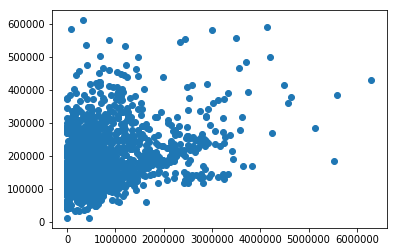

In [94]:
plt.scatter(df['Bsmt Unf SF'] * df['Total Bsmt SF'], df['SalePrice'])

In [ ]:
df['Overall Qual * Exter Qual'] = df['Overall Qual'] * df['Exter Qual']

In [ ]:
df.corr().loc['Overall Qual * Exter Qual', 'SalePrice']

In [ ]:
df.corr().loc[:, 'SalePrice'][abs(df.corr().loc[:, 'SalePrice']) < 0.3]

In [95]:
dummy_cols = [col for col in df.columns if df[col].dtype == 'uint8']

In [96]:
df.corr()

Id       PID  Lot Frontage  Lot Area  Overall Qual  \
Id               1.000000  0.175567     -0.014321  0.033068     -0.061304   
PID              0.175567  1.000000     -0.071749  0.021931     -0.264771   
Lot Frontage    -0.014321 -0.071749      1.000000  0.590271      0.168815   
Lot Area         0.033068  0.021931      0.590271  1.000000      0.108310   
Overall Qual    -0.061304 -0.264771      0.168815  0.108310      1.000000   
Overall Cond    -0.026218  0.105537     -0.035328 -0.022437     -0.081320   
Year Built      -0.063859 -0.346151      0.080926  0.037067      0.602590   
Year Remod/Add  -0.090577 -0.176795      0.060941  0.049245      0.584940   
Mas Vnr Area    -0.035609 -0.241874      0.215318  0.170131      0.429659   
Exter Qual      -0.071411 -0.225474      0.125143  0.091525      0.740106   
Exter Cond      -0.017488  0.040210      0.011648  0.020300      0.020101   
Bsmt Qual       -0.045879 -0.196722      0.095907  0.071051      0.655418   
Bsmt Cond        0.007737 -0.105611      0.022718  0.001306      0.298194   
BsmtFin SF 1    -0.045985 -0.086221      0.210811  0.219680      0.278613   
BsmtFin SF 2     0.000856 -0.012857      0.045337  0.042790     -0.028430   
Bsmt Unf SF      0.008833 -0.110455      0.124798  0.044907      0.275280   
Total Bsmt SF   -0.038179 -0.202774      0.356939  0.285942      0.548608   
Heating QC      -0.029595 -0.102892      0.065262  0.025228      0.475380   
Central Air     -0.047387 -0.201503      0.068655  0.056958      0.296364   
1st Flr SF      -0.022808 -0.150417      0.456821  0.370316      0.484813   
2nd Flr SF      -0.009021 -0.005502      0.029313  0.031587      0.228148   
Low Qual Fin SF  0.011762  0.072487     -0.002898  0.001533     -0.052542   
Gr Liv Area     -0.024473 -0.115766      0.384655  0.318904      0.571591   
Bsmt Full Bath  -0.033036 -0.030150      0.109439  0.116088      0.174914   
Bsmt Half Bath   0.014496 -0.001818     -0.008964  0.029963     -0.047422   
Full Bath       -0.059677 -0.181061      0.157861  0.119553      0.517092   
Half Bath       -0.041837 -0.164101      0.035589  0.046743      0.274927   
Bedroom AbvGr    0.010430  0.008235      0.221624  0.133040      0.053850   
Kitchen AbvGr   -0.002323  0.068779      0.021292 -0.013111     -0.171415   
Kitchen Qual    -0.065988 -0.196227      0.157437  0.114223      0.692809   
...                   ...       ...           ...       ...           ...   
Functional_Maj2 -0.001229  0.043686     -0.005576 -0.000873     -0.080975   
Functional_Sev  -0.005137  0.000990      0.019967  0.003153     -0.013470   
Functional_Typ  -0.016009 -0.087417     -0.063377 -0.115146      0.194675   
Functional_Sal   0.012047  0.032081      0.000441  0.011218     -0.079255   
Functional_Mod  -0.010195  0.049384      0.054675  0.102782     -0.099459   
Paved Drive_N    0.057252  0.207363     -0.034199 -0.001892     -0.308291   
Paved Drive_P    0.025573  0.114227      0.011875  0.016988     -0.091347   
Sale Type_ConLw -0.001413  0.050459     -0.026224 -0.007305     -0.031723   
Sale Type_ConLI -0.047826 -0.023834      0.011343 -0.001350      0.018778   
Sale Type_COD   -0.031577 -0.008003     -0.007445 -0.010673     -0.095594   
Sale Type_ConLD -0.037139  0.026568      0.023700 -0.007687     -0.073237   
Sale Type_Con   -0.029644  0.001239     -0.026177  0.010649      0.019725   
Sale Type_Oth   -0.029735  0.023154     -0.018043 -0.011440     -0.050085   
Sale Type_CWD    0.039370  0.002789     -0.005380  0.008464      0.018951   
Sale Type_WD    -0.048362  0.102555     -0.076495 -0.027443     -0.196960   
Mo Sold_2       -0.029005 -0.005473     -0.002857 -0.019892      0.011102   
Mo Sold_3       -0.034748  0.014942      0.005719  0.004130     -0.023878   
Mo Sold_4       -0.080425  0.023887     -0.046792 -0.035856     -0.042778   
Mo Sold_5       -0.046673  0.034161      0.000486 -0.033683     -0.008647   
Mo Sold_6       -0.040102  0.017384      0.044952  0.057858     -0.009276   
Mo Sold_7        0.

In [97]:
df.corr().loc['SalePrice',:].sort_values()

Mas Vnr Type_None      -0.424512
Garage Type_Detchd     -0.369449
Foundation_CBlock      -0.356187
Lot Shape_Reg          -0.306704
MS Zoning_RM           -0.280768
Paved Drive_N          -0.273915
PID                    -0.255293
Roof Style_Gable       -0.249497
MS SubClass_30         -0.248799
Garage Type_NA         -0.231243
Garage Finish_NA       -0.231243
Foundation_BrkTil      -0.230024
Sale Type_WD           -0.214881
Neighborhood_OldTown   -0.208617
Electrical_FuseA       -0.199599
House Style_1.5Fin     -0.196051
Exterior 1st_Wd Sdng   -0.191735
Neighborhood_IDOTRR    -0.189727
Neighborhood_NAmes     -0.189652
MS SubClass_50         -0.182567
Neighborhood_Edwards   -0.179408
Exterior 2nd_Wd Sdng   -0.173208
BsmtFin Type 1_NA      -0.160447
BsmtFin Type 2_NA      -0.155051
Bsmt Exposure_NA       -0.153122
BsmtFin Type 1_Rec     -0.151113
Exterior 1st_MetalSd   -0.148547
Exterior 2nd_MetalSd   -0.139558
Enclosed Porch         -0.135516
Neighborhood_Sawyer    -0.133856
          

Features with strong correlation with saleprice:
- `'Overall Qual'`
- `'Gr Liv Area'`
- `'Garage Area'`

# Step 4: Create Model

## Model 1: Overall Quality, Gr Liv Area, Garage Area

In [ ]:
features = ['Overall Qual', 'Gr Liv Area', 'Garage Area']

In [ ]:
X = df[features]
y = df['SalePrice']

```X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)```

```lr = LinearRegression()```

```kf = KFold(n_splits = 5, shuffle=True, random_state=8)```

```scores = cross_val_score(lr, X_train, y_train, cv=kf)```

```print(scores)```

``print(scores.mean())``

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

lr = LinearRegression()

kf = KFold(n_splits = 5, shuffle=True, random_state=8)

scores = cross_val_score(lr, X_train, y_train, cv=kf)
print(scores)
print(scores.mean())

In [ ]:
lr.fit(X_train, y_train)
lr.score(X_train, y_train)

In [ ]:
lr.score(X_test, y_test)

In [ ]:
X_holdout = test_data[features]
predictions = lr.predict(X_holdout)

In [ ]:
submission = pd.DataFrame(predictions,index=test_data['Id'])

submission.rename(columns={0:'SalePrice'}, inplace=True)
submission.head()

In [ ]:
submission.to_csv('../Data/submission.csv')

## Model 2 - Model 1 + neighborhood dummies

In [ ]:
df.shape

In [ ]:
houses = pd.get_dummies(df, columns=['Neighborhood'], drop_first=True)

In [ ]:
houses.shape

In [ ]:
neighborhoods = df['Neighborhood'].unique().tolist()

In [ ]:
neighborhoods

In [ ]:
avg_sale = [df[df['Neighborhood'] == neighborhoods[i]]['SalePrice'].mean() for i in range(0, len(neighborhoods))]
nei_var = [df[df['Neighborhood'] == neighborhoods[i]]['SalePrice'].std() for i in range(0, len(neighborhoods))]
for i in range(len(avg_sale)):
    print(neighborhoods[i], avg_sale[i])
    print(neighborhoods[i], nei_var[i])

In [ ]:
dummies = [col for col in houses.columns if 'Neighborhood' in col]
type(dummies)

In [ ]:
features_2 = features

In [ ]:
features_2.extend(dummies)

In [ ]:
features_2

In [ ]:
X_2 = houses[features_2]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_2, y, test_size=0.2, random_state=8)

lr = LinearRegression()

kf = KFold(n_splits = 5, shuffle=True, random_state=8)

scores = cross_val_score(lr, X_train, y_train, cv=kf) 
print(scores) 
print(scores.mean())

In [ ]:
lr.fit(X_train, y_train)

In [ ]:
lr.score(X_train, y_train)

In [ ]:
lr.score(X_test, y_test)

In [ ]:
test_data_copy = test_data

In [ ]:
test_data.shape

In [ ]:
test_data_copy.shape

In [ ]:
test_data_copy['Neighborhood'] = test_data_copy['Neighborhood'].map(lambda cell: 
                                            'Other' if cell in ['Blueste', 'Greens', 'GrnHill', 'Landmrk'] else cell)

In [ ]:
test_data_copy.shape

In [ ]:
test_data_copy = pd.get_dummies(test_data_copy, columns=['Neighborhood'], drop_first=True)

In [ ]:
X_train.shape

In [ ]:
X_hold = test_data_copy[features_2]

In [ ]:
X_hold.shape

In [ ]:
predictions = lr.predict(X_hold)

In [ ]:
submission = pd.DataFrame(predictions, index = test_data['Id'])

In [ ]:
submission.rename(columns={0:'SalePrice'}, inplace=True)
submission.head()

In [ ]:
submission.to_csv('../Data/submission.csv')

# Model 3

In [ ]:
sales_corr = df.corr().loc[:, 'SalePrice']
features_3 = [col for col in df.columns if col != 'SalePrice']
features_3

In [ ]:
strong_corrs

In [ ]:
X = df[features_3]
y = df['SalePrice']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [ ]:
corr = df.corr()
strong_corrs = {}
for i in range(corr.shape[0]):
    for j in range(corr.shape[1]):
        if i == j:
            continue
        if abs(corr.iloc[i, j]) > 0.7:
            if strong_corrs.get(corr.columns[i]):
                strong_corrs[corr.columns[i]].append(corr.columns[j])
            else:
                strong_corrs[corr.columns[i]] = [corr.columns[j]]

In [ ]:
from sklearn.preprocessing import StandardScaler

In [ ]:
ss = StandardScaler()

In [ ]:
X_train_scaled = ss.fit_transform(X_train)
X_test_scaled = ss.transform(X_test)

In [ ]:
lr = LinearRegression()

In [ ]:
cross_val_score(lr, X_train_scaled, y_train)

In [ ]:
lr.fit(X_train_scaled, y_train)

In [ ]:
lr.score(X_train_scaled, y_train)

In [ ]:
lr.score(X_test_scaled, y_test)

In [ ]:
X_holdout = test_data[features_3]
X_holdout_scaled = ss.transform(X_holdout)

predictions = lr.predict(X_holdout_scaled)

submission = pd.DataFrame(predictions,index=test_data['Id'])

submission.rename(columns={0:'SalePrice'}, inplace=True)
submission.head()

submission.to_csv('../Data/submission.csv')

## Model 4: Everything

In [742]:
unused_cols = ['SalePrice', 'Id', 'PID']
features_4 = [col for col in df.columns if col not in unused_cols]

In [743]:
X4 = df[features_4]
y = df['SalePrice']

X4_train, X4_test, y_train, y_test = train_test_split(X4, y, test_size=0.2, random_state=8)

In [744]:
X4.shape

(2048, 259)

In [745]:
linreg = LinearRegression()

In [746]:
ss = StandardScaler()

In [747]:
X4_train_scaled = ss.fit_transform(X4_train)
X4_test_scaled = ss.transform(X4_test)

In [748]:
cross_val_score(linreg, X4_train_scaled, y_train).mean()

-3.651435431625854e+24

### Lasso CV to cull features

In [749]:
lasso_cv = LassoCV(n_alphas = 1000, cv=10, max_iter=2500)

In [750]:
scores_lasso = cross_val_score(lasso_cv, X4_train_scaled, y_train)
print(scores_lasso)
print(scores_lasso.mean())

[0.90217078 0.76312743 0.89823991]
0.854512705246202


In [751]:
lasso_cv.fit(X4_train_scaled, y_train)

LassoCV(alphas=None, copy_X=True, cv=10, eps=0.001, fit_intercept=True,
    max_iter=2500, n_alphas=1000, n_jobs=1, normalize=False,
    positive=False, precompute='auto', random_state=None,
    selection='cyclic', tol=0.0001, verbose=False)

In [752]:
lasso_cv.score(X4_train_scaled, y_train)

0.9227283801855031

In [753]:
lasso_cv.score(X4_test_scaled, y_test)

0.8365493263286669

In [754]:
lasso_cv.alpha_

512.3343985552967

In [121]:
lasso_coefs = pd.DataFrame(data=lasso_cv.coef_, index=X4.columns)

In [122]:
zero_coefs = lasso_coefs[lasso_coefs[0] == 0].index.tolist()

In [165]:
zero_coefs

['Exter Cond',
 'Bsmt Cond',
 'BsmtFin SF 2',
 'Bsmt Unf SF',
 'Central Air',
 '2nd Flr SF',
 'Full Bath',
 'Garage Yr Blt',
 'Garage Qual',
 'Garage Cond',
 'Enclosed Porch',
 '3Ssn Porch',
 'Pool Area',
 'Misc Val',
 'Misc Feature_Shed',
 'Misc Feature_Elev',
 'Misc Feature_Gar2',
 'Misc Feature_NA',
 'Garage Type_CarPort',
 'Garage Type_Detchd',
 'Bldg Type_TwnhsE',
 'Bldg Type_Duplex',
 'BsmtFin Type 1_Unf',
 'BsmtFin Type 1_BLQ',
 'BsmtFin Type 1_Rec',
 'BsmtFin Type 1_ALQ',
 'BsmtFin Type 2_Unf',
 'BsmtFin Type 2_BLQ',
 'BsmtFin Type 2_NA',
 'Exterior 1st_AsbShng',
 'Exterior 1st_CemntBd',
 'Exterior 1st_WdShing',
 'Exterior 1st_CBlock',
 'Exterior 1st_Plywood',
 'Exterior 1st_AsphShn',
 'Exterior 1st_MetalSd',
 'Exterior 1st_VinylSd',
 'Exterior 1st_BrkComm',
 'Exterior 2nd_AsbShng',
 'Exterior 2nd_Wd Sdng',
 'Exterior 2nd_CBlock',
 'Exterior 2nd_Stucco',
 'Exterior 2nd_MetalSd',
 'Exterior 2nd_Stone',
 'Exterior 2nd_Wd Shng',
 'Exterior 2nd_Brk Cmn',
 'Foundation_CBlock',
 'Fou

In [755]:
mean_squared_error(y_test, lasso_cv.predict(X4_test_scaled))**0.5

33723.313027889766

In [ ]:
X_holdout = test_data[features_4]
X_holdout_scaled = ss.transform(X_holdout)

predictions = lasso_cv.predict(X_holdout_scaled)

submission = pd.DataFrame(predictions,index=test_data['Id'])

submission.rename(columns={0:'SalePrice'}, inplace=True)
submission.head()

In [ ]:
submission.to_csv('../Data/submission.csv')

### Model 5: run LassoCV on polynomial predictor matrix

In [756]:
X5 = df[features_4]
y = df['SalePrice']

In [757]:
poly = PolynomialFeatures()

In [758]:
X_poly = poly.fit_transform(X5)

In [759]:
X_poly_train, X_poly_test, y_train, y_test = train_test_split(X_poly, y, test_size=0.2, random_state=42)

In [760]:
ss = StandardScaler()
X_poly_train_scaled = ss.fit_transform(X_poly_train)
X_poly_test_scaled = ss.transform(X_poly_test)

In [762]:
lasso_poly_100 = LassoCV(cv = 5, max_iter=2000, verbose=2)
scores_lasso_poly = cross_val_score(lasso_poly_100, X_poly_train_scaled, y_train)
print(scores_lasso_poly)
print(scores_lasso_poly.mean())

Path: 000 out of 100
Path: 001 out of 100
Path: 002 out of 100
Path: 003 out of 100
Path: 004 out of 100
Path: 005 out of 100
Path: 006 out of 100
Path: 007 out of 100
Path: 008 out of 100
Path: 009 out of 100
Path: 010 out of 100
Path: 011 out of 100
Path: 012 out of 100
Path: 013 out of 100
Path: 014 out of 100
Path: 015 out of 100
Path: 016 out of 100
Path: 017 out of 100
Path: 018 out of 100
Path: 019 out of 100
Path: 020 out of 100
Path: 021 out of 100
Path: 022 out of 100
Path: 023 out of 100
Path: 024 out of 100
Path: 025 out of 100
Path: 026 out of 100
Path: 027 out of 100
Path: 028 out of 100
Path: 029 out of 100
Path: 030 out of 100
Path: 031 out of 100
Path: 032 out of 100
Path: 033 out of 100
Path: 034 out of 100
Path: 035 out of 100
Path: 036 out of 100
Path: 037 out of 100
Path: 038 out of 100
Path: 039 out of 100
Path: 040 out of 100
Path: 041 out of 100
Path: 042 out of 100
Path: 043 out of 100
Path: 044 out of 100
Path: 045 out of 100
Path: 046 out of 100
Path: 047 out

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  3.4min remaining:    0.0s


Path: 000 out of 100
Path: 001 out of 100
Path: 002 out of 100
Path: 003 out of 100
Path: 004 out of 100
Path: 005 out of 100
Path: 006 out of 100
Path: 007 out of 100
Path: 008 out of 100
Path: 009 out of 100
Path: 010 out of 100
Path: 011 out of 100
Path: 012 out of 100
Path: 013 out of 100
Path: 014 out of 100
Path: 015 out of 100
Path: 016 out of 100
Path: 017 out of 100
Path: 018 out of 100
Path: 019 out of 100
Path: 020 out of 100
Path: 021 out of 100
Path: 022 out of 100
Path: 023 out of 100
Path: 024 out of 100
Path: 025 out of 100
Path: 026 out of 100
Path: 027 out of 100
Path: 028 out of 100
Path: 029 out of 100
Path: 030 out of 100
Path: 031 out of 100
Path: 032 out of 100
Path: 033 out of 100
Path: 034 out of 100
Path: 035 out of 100
Path: 036 out of 100
Path: 037 out of 100
Path: 038 out of 100
Path: 039 out of 100
Path: 040 out of 100
Path: 041 out of 100
Path: 042 out of 100
Path: 043 out of 100
Path: 044 out of 100
Path: 045 out of 100
Path: 046 out of 100
Path: 047 out

Path: 091 out of 100
Path: 092 out of 100
Path: 093 out of 100
Path: 094 out of 100
Path: 095 out of 100
Path: 096 out of 100
Path: 097 out of 100
Path: 098 out of 100
Path: 099 out of 100


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed: 19.4min finished


Path: 000 out of 100
Path: 001 out of 100
Path: 002 out of 100
Path: 003 out of 100
Path: 004 out of 100
Path: 005 out of 100
Path: 006 out of 100
Path: 007 out of 100
Path: 008 out of 100
Path: 009 out of 100
Path: 010 out of 100
Path: 011 out of 100
Path: 012 out of 100
Path: 013 out of 100
Path: 014 out of 100
Path: 015 out of 100
Path: 016 out of 100
Path: 017 out of 100
Path: 018 out of 100
Path: 019 out of 100
Path: 020 out of 100
Path: 021 out of 100
Path: 022 out of 100
Path: 023 out of 100
Path: 024 out of 100
Path: 025 out of 100
Path: 026 out of 100
Path: 027 out of 100
Path: 028 out of 100
Path: 029 out of 100
Path: 030 out of 100
Path: 031 out of 100
Path: 032 out of 100
Path: 033 out of 100
Path: 034 out of 100
Path: 035 out of 100
Path: 036 out of 100
Path: 037 out of 100
Path: 038 out of 100
Path: 039 out of 100
Path: 040 out of 100
Path: 041 out of 100
Path: 042 out of 100
Path: 043 out of 100
Path: 044 out of 100
Path: 045 out of 100
Path: 046 out of 100
Path: 047 out

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  4.0min remaining:    0.0s


Path: 000 out of 100
Path: 001 out of 100
Path: 002 out of 100
Path: 003 out of 100
Path: 004 out of 100
Path: 005 out of 100
Path: 006 out of 100
Path: 007 out of 100
Path: 008 out of 100
Path: 009 out of 100
Path: 010 out of 100
Path: 011 out of 100
Path: 012 out of 100
Path: 013 out of 100
Path: 014 out of 100
Path: 015 out of 100
Path: 016 out of 100
Path: 017 out of 100
Path: 018 out of 100
Path: 019 out of 100
Path: 020 out of 100
Path: 021 out of 100
Path: 022 out of 100
Path: 023 out of 100
Path: 024 out of 100
Path: 025 out of 100
Path: 026 out of 100
Path: 027 out of 100
Path: 028 out of 100
Path: 029 out of 100
Path: 030 out of 100
Path: 031 out of 100
Path: 032 out of 100
Path: 033 out of 100
Path: 034 out of 100
Path: 035 out of 100
Path: 036 out of 100
Path: 037 out of 100
Path: 038 out of 100
Path: 039 out of 100
Path: 040 out of 100
Path: 041 out of 100
Path: 042 out of 100
Path: 043 out of 100
Path: 044 out of 100
Path: 045 out of 100
Path: 046 out of 100
Path: 047 out

Path: 091 out of 100
Path: 092 out of 100
Path: 093 out of 100
Path: 094 out of 100
Path: 095 out of 100
Path: 096 out of 100
Path: 097 out of 100
Path: 098 out of 100
Path: 099 out of 100


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed: 16.1min finished


Path: 000 out of 100
Path: 001 out of 100
Path: 002 out of 100
Path: 003 out of 100
Path: 004 out of 100
Path: 005 out of 100
Path: 006 out of 100
Path: 007 out of 100
Path: 008 out of 100
Path: 009 out of 100
Path: 010 out of 100
Path: 011 out of 100
Path: 012 out of 100
Path: 013 out of 100
Path: 014 out of 100
Path: 015 out of 100
Path: 016 out of 100
Path: 017 out of 100
Path: 018 out of 100
Path: 019 out of 100
Path: 020 out of 100
Path: 021 out of 100
Path: 022 out of 100
Path: 023 out of 100
Path: 024 out of 100
Path: 025 out of 100
Path: 026 out of 100
Path: 027 out of 100
Path: 028 out of 100
Path: 029 out of 100
Path: 030 out of 100
Path: 031 out of 100
Path: 032 out of 100
Path: 033 out of 100
Path: 034 out of 100
Path: 035 out of 100
Path: 036 out of 100
Path: 037 out of 100
Path: 038 out of 100
Path: 039 out of 100
Path: 040 out of 100
Path: 041 out of 100
Path: 042 out of 100
Path: 043 out of 100
Path: 044 out of 100
Path: 045 out of 100
Path: 046 out of 100
Path: 047 out

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  4.2min remaining:    0.0s


Path: 000 out of 100
Path: 001 out of 100
Path: 002 out of 100
Path: 003 out of 100
Path: 004 out of 100
Path: 005 out of 100
Path: 006 out of 100
Path: 007 out of 100
Path: 008 out of 100
Path: 009 out of 100
Path: 010 out of 100
Path: 011 out of 100
Path: 012 out of 100
Path: 013 out of 100
Path: 014 out of 100
Path: 015 out of 100
Path: 016 out of 100
Path: 017 out of 100
Path: 018 out of 100
Path: 019 out of 100
Path: 020 out of 100
Path: 021 out of 100
Path: 022 out of 100
Path: 023 out of 100
Path: 024 out of 100
Path: 025 out of 100
Path: 026 out of 100
Path: 027 out of 100
Path: 028 out of 100
Path: 029 out of 100
Path: 030 out of 100
Path: 031 out of 100
Path: 032 out of 100
Path: 033 out of 100
Path: 034 out of 100
Path: 035 out of 100
Path: 036 out of 100
Path: 037 out of 100
Path: 038 out of 100
Path: 039 out of 100
Path: 040 out of 100
Path: 041 out of 100
Path: 042 out of 100
Path: 043 out of 100
Path: 044 out of 100
Path: 045 out of 100
Path: 046 out of 100
Path: 047 out

Path: 091 out of 100
Path: 092 out of 100
Path: 093 out of 100
Path: 094 out of 100
Path: 095 out of 100
Path: 096 out of 100
Path: 097 out of 100
Path: 098 out of 100
Path: 099 out of 100


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed: 20.6min finished


[0.93363725 0.80776386 0.75453056]
0.8319772238520474


In [764]:
X_poly_train_scaled.shape

(1638, 33930)

In [ ]:
lasso_poly_250 = LassoCV(n_alphas=250, cv=10, max_iter=2000)
cross_val_score(lasso_poly_250, X_poly_train_scaled, y_train).mean())

In [766]:
lasso_poly_100.set_params(verbose=1)

LassoCV(alphas=None, copy_X=True, cv=5, eps=0.001, fit_intercept=True,
    max_iter=2000, n_alphas=100, n_jobs=1, normalize=False, positive=False,
    precompute='auto', random_state=None, selection='cyclic', tol=0.0001,
    verbose=1)

In [767]:
lasso_poly_100.fit(X_poly_train_scaled, y_train)
lasso_poly_100.score(X_poly_test_scaled, y_test)

....................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed: 29.4min finished


0.9060836203076095

In [768]:
lasso_poly_100.score(X_poly_train_scaled, y_train)

0.9589447296117782

In [769]:
X5_ho = test_data[features_4]

X5_poly_ho = poly.transform(X5_ho)

X5_poly_ho_scaled = ss.transform(X5_poly_ho)

In [770]:
poly_preds = lasso_poly_100.predict(X5_poly_ho_scaled)

In [772]:
X5_ho.head()

Lot Frontage  Lot Area  Overall Qual  Overall Cond  Year Built  \
0     69.000000      9142             6             8        1910   
1     73.430260      9662             5             4        1977   
2     58.000000     17104             7             5        2006   
3     60.000000      8520             5             6        1923   
4     77.783584      9500             6             5        1963   

   Year Remod/Add  Mas Vnr Area  Exter Qual  Exter Cond  Bsmt Qual  \
0            1950           0.0           3           2          2   
1            1977           0.0           3           3          4   
2            2006           0.0           4           3          4   
3            2006           0.0           4           3          3   
4            1963         247.0           3           3          4   

       ...       Mo Sold_7  Mo Sold_8  Mo Sold_9  Mo Sold_10  Mo Sold_11  \
0      ...               0          0          0           0           0   
1      ...               0          1          0           0           0   
2      ...               0          0          1           0           0   
3      ...               1          0          0           0           0   
4      ...               1          0          0           0           0   

   Mo Sold_12  Yr Sold_2007  Yr Sold_2008  Yr Sold_2009  Yr Sold_2010  
0           0             0             0             0             0  
1           0             0             0             0             0  
2           0             0             0             0             0  
3           0             1             0             0             0  
4           0             0             0             1             0  

[5 rows x 259 columns]

In [773]:
test_data.head()

Id        PID  Lot Frontage  Lot Area  Overall Qual  Overall Cond  \
0  2658  902301120     69.000000      9142             6             8   
1  2718  905108090     73.430260      9662             5             4   
2  2414  528218130     58.000000     17104             7             5   
3  1989  902207150     60.000000      8520             5             6   
4   625  535105100     77.783584      9500             6             5   

   Year Built  Year Remod/Add  Mas Vnr Area  Exter Qual      ...       \
0        1910            1950           0.0           3      ...        
1        1977            1977           0.0           3      ...        
2        2006            2006           0.0           4      ...        
3        1923            2006           0.0           4      ...        
4        1963            1963         247.0           3      ...        

   Mo Sold_7  Mo Sold_8  Mo Sold_9  Mo Sold_10  Mo Sold_11  Mo Sold_12  \
0          0          0          0           0           0           0   
1          0          1          0           0           0           0   
2          0          0          1           0           0           0   
3          1          0          0           0           0           0   
4          1          0          0           0           0           0   

   Yr Sold_2007  Yr Sold_2008  Yr Sold_2009  Yr Sold_2010  
0             0             0             0             0  
1             0             0             0             0  
2             0             0             0             0  
3             1             0             0             0  
4             0             0             1             0  

[5 rows x 261 columns]

In [776]:
submission = pd.DataFrame(data=poly_preds, index=test_data['Id'])

submission.columns = ['SalePrice']
submission.to_csv('../Data/submission.csv')

In [143]:
lasso_poly.fit(X_poly_train_scaled, y_train)
lasso_poly.score(X_poly_test_scaled, y_test)

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of

0.870785806984144

In [ ]:
lasso_poly_250.fit(X_poly_train_scaled, y_train)
lasso_poly_100.score(X_poly_test_scaled, y_test)

In [144]:
X5_holdout = test_data[features_4]
X_holdout_poly = poly.transform(X5_holdout)
X_holdout_poly_scaled = ss.transform(X_holdout_poly)

In [145]:
pred_lasso_poly = lasso_poly.predict(X_holdout_poly_scaled)

In [147]:
pred_lasso_p100 = lasso_poly_100.predict(X_holdout_poly_scaled)

In [ ]:
pred_lasso_p250 = lasso_poly_250.predict(X_holdout_poly_scaled)

In [148]:
submission = pd.DataFrame(data=pred_lasso_p100, index=test_data['Id'])

submission.rename(columns={0:'SalePrice'}, inplace=True)

submission.to_csv('../Data/submission.csv')

In [153]:
lasso_coefs = pd.DataFrame(data=lasso_poly_100.coef_, index=poly.get_feature_names())

In [156]:
lasso_coefs['abs'] = abs(lasso_coefs[0])

In [159]:
X5.columns[117], X5.columns[208]

('Land Contour_Bnk', 'Bsmt Exposure_Gd')

In [160]:
np.corrcoef((df['Land Contour_Bnk'] * df['Bsmt Exposure_Gd']), y=df['SalePrice'])

array([[ 1.        , -0.00377225],
       [-0.00377225,  1.        ]])

In [161]:
X5.columns[2], X5.columns[20]

('Overall Qual', 'Gr Liv Area')

In [162]:
np.corrcoef((df['Overall Qual'] * df['Gr Liv Area']), y=df['SalePrice'])

array([[1.        , 0.83692478],
       [0.83692478, 1.        ]])

In [163]:
np.corrcoef((df[X5.columns[20]] * df[X5.columns[27]]), y=df['SalePrice'])

array([[1.        , 0.81514075],
       [0.81514075, 1.        ]])

In [158]:
lasso_coefs[lasso_coefs['abs'] > 1].sort_values('abs', ascending=False)

0           abs
x117 x208 -18400.338165  18400.338165
x2 x20      6178.151552   6178.151552
x2 x14      6135.721850   6135.721850
x20 x27     5428.054220   5428.054220
x7 x20      5028.262212   5028.262212
x2 x33      4126.227452   4126.227452
x4 x5       3620.265112   3620.265112
x3 x20      3557.412143   3557.412143
x14 x32     3491.064858   3491.064858
x11 x155    3157.700335   3157.700335
x9 x20      3123.276576   3123.276576
x7 x17      3025.072433   3025.072433
x64 x184   -3011.816765   3011.816765
x6 x155     2983.107099   2983.107099
x11 x64     2972.415577   2972.415577
x2^2        2876.135775   2876.135775
x172 x206   2802.669537   2802.669537
x6 x172     2690.595398   2690.595398
x11 x198    2535.402005   2535.402005
x6 x131     2513.219671   2513.219671
x20 x218    2411.008697   2411.008697
x75 x240    2335.074891   2335.074891
x1 x3       2318.362321   2318.362321
x6 x175     2294.265608   2294.265608
x22 x75    -2287.614503   2287.614503
x29 x172    2128.111180   2128.111180
x15 x20     2117.007280   2117.007280
x40 x131    2054.626616   2054.626616
x33 x155    2019.855382   2019.855382
x155 x230  -1975.787794   1975.787794
...                 ...           ...
x66 x139       3.547437      3.547437
x40 x65        3.501317      3.501317
x95 x131      -3.403222      3.403222
x54 x92        3.035274      3.035274
x189 x217     -2.981761      2.981761
x91 x167       2.973796      2.973796
x145 x159     -2.669080      2.669080
x144 x243      2.495938      2.495938
x61 x92        2.269684      2.269684
x130 x225      2.127334      2.127334
x36 x182       2.022517      2.022517
x47 x217      -2.016244      2.016244
x139 x150      1.964659      1.964659
x229 x243      1.865534      1.865534
x21 x240       1.839448      1.839448
x122 x208     -1.782878      1.782878
x216 x236     -1.763078      1.763078
x12 x80       -1.723349      1.723349
x80 x229      -1.608758      1.608758
x68 x139      -1.589175      1.589175
x11 x217      -1.588820      1.588820
x54 x137      -1.512683      1.512683
x194 x241      1.479047      1.479047
x15 x217      -1.384141      1.384141
x197 x229     -1.286353      1.286353
x22 x92       -1.275232      1.275232
x17 x114      -1.237151      1.237151
x217          -1.094593      1.094593
x55 x211      -1.024939      1.024939
x63 x128       1.020614      1.020614

[943 rows x 2 columns]

In [ ]:
lasso.fit(X5_train_scaled, y_train)

In [ ]:
lasso.score(X5_train_scaled, y_train)

In [ ]:
lasso.score(X5_test_scaled, y_test)

In [ ]:
lasso_coefs = pd.DataFrame(data=lasso.coef_, index=X5.columns)

In [ ]:
lasso_coefs[lasso_coefs[0] == 0]

In [ ]:
ridge = RidgeCV(alphas=np.logspace(0, 5, 500))

In [ ]:
ridge.fit(X5_train_scaled, y_train)

In [ ]:
ridge.score(X5_test_scaled, y_test)

In [ ]:
lr = LinearRegression()

In [ ]:
en = ElasticNetCV(l1_ratio = [.1, .5, .7, .9, .95, .99, 1], n_alphas=250)

In [ ]:
en.fit(X5_train_scaled, y_train)

In [ ]:
en.score(X5_train_scaled, y_train)

In [ ]:
en.score(X5_test_scaled, y_test)

### Polynomial Features

In [198]:
poly = PolynomialFeatures(interaction_only=True)

In [205]:
X4_poly = poly.fit_transform(X4)
y = df['SalePrice']

In [206]:
X4p_train, X4p_test, y_train, y_test = train_test_split(X4_poly, y, test_size=0.2)

In [207]:
ss = StandardScaler()

In [208]:
X_ptrain_scaled = ss.fit_transform(X4p_train)
X_ptest_scaled = ss.transform(X4p_test)

In [211]:
lassoCV = LassoCV(max_iter=1500)

In [212]:
cross_val_score(lassoCV, X_ptrain_scaled, y_train)

array([0.917469  , 0.79318231, 0.82160136])

In [213]:
lassoCV.fit(X_ptrain_scaled, y_train)

LassoCV(alphas=None, copy_X=True, cv=None, eps=0.001, fit_intercept=True,
    max_iter=1500, n_alphas=100, n_jobs=1, normalize=False, positive=False,
    precompute='auto', random_state=None, selection='cyclic', tol=0.0001,
    verbose=False)

In [214]:
lassoCV.score(X_ptest_scaled, y_test)

0.6662206077481582

In [ ]:
lassoCV_500 = LassoCV(n_alphas=500, max_iter=1500)
scores_p500 = cross_val_score(lassoCV_500, X_ptrain_scaled, y_train)
print(scores_p500)
print(scores_p500.mean())
lassoCV_500.fit(X_ptrain_scaled, y_train)
lassoCV_500.score(X_ptest_scaled, y_test)

In [ ]:
lasso_coefs = pd.DataFrame(data=lassoCV.coef_, index=poly.get_feature_names())

In [ ]:
lasso_coefs.head()

In [ ]:
lasso_coefs[lasso_coefs[0] != 0].sort_values(0, ascending=False)

In [ ]:
interaction_term_list = lasso_coefs.index.tolist()

In [ ]:
meaningful_interactions = lasso_coefs[lasso_coefs[0] != 0].index.tolist()

In [ ]:
poly_pulls = [interaction_term_list.index(item) for item in meaningful_interactions]

In [ ]:
poly_pulls[0]

In [ ]:
lasso_coefs.index.tolist()

In [ ]:
interaction_term_list[5]

In [ ]:
lasso_coefs.loc['x4',:]

In [ ]:
meaningful_interactions = [ind.replace('x','').replace(' ','*') for ind in meaningful_interactions]

In [ ]:
meaningful_interactions

In [ ]:
mi = [item.split('*') for item in meaningful_interactions]
            

In [ ]:
singles = []
inters = []
for item in mi:
    if len(item) == 1:
        singles.append(X4.columns[int(item[0])])
    else:
        inters.append('*'.join([X4.columns[int(item[0])], X4.columns[int(item[1])]]))

In [ ]:
singles

In [ ]:
len(inters) + X4.shape[1]

In [ ]:
X4.shape

In [ ]:
X4.columns[0]

In [ ]:
X6 = X4

In [ ]:
for item in inters:
    temp = item.split('*')
    X6[item] = X6[temp[0]]*X6[temp[1]]

In [ ]:
X4

In [ ]:
X6

In [ ]:
interaction_term_list

In [ ]:
X4_poly[0][lasso_coefs.index.tolist().index('x0 x1')]

In [ ]:
X4.iloc[0,0] * X4.iloc[0,1]

In [ ]:
poly.get_feature_names().index('x208 x228')

In [ ]:
lassoCV.coef_[26981]

In [ ]:
len(X4_poly)

In [ ]:
import itertools

Kitchen Qual            0.691939
Gr Liv Area             0.697821
Exter Qual              0.712901
Overall Qual

In [ ]:
temp = ['Overall Qual', 'Exter Qual', 'Gr Liv Area', 'Kitchen Qual']

In [ ]:
for r in range(1, len(temp)):
    for combo in itertools.combinations(temp, r):
        print(list(combo))

In [ ]:
def best_by_r2(features, target, df):
    # Create baseline feature list, r2 score, and y value
    feature_list = []
    score = 0
    y = df[target]
    
    # Iterate through all possible combinations of features
    for r in range(1, len(features)):
        for combo in itertools.combinations(features, r):
            
            # Make X using unique combination of features
            X = df[list(combo)]
            
            # Train/test split
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=8)
            
            # Scale and transform X_train and X_test
            ss=StandardScaler()
            ss.fit(X_train)
            X_train_scaled = ss.transform(X_train)
            X_test_scaled = ss.transform(X_test)
            
            # Fit new model
            lr = LinearRegression()
            lr.fit(X_train_scaled, y_train)
            
            # Score model on test data
            new_score = lr.score(X_test_scaled, y_test)
            
            # If new score is better than current high score, make feature list equal to current X features
            # and score equal to new score
            if new_score > score:
                feature_list = list(X.columns)
                score = new_score
        print(len(features)-r)
    return feature_list

In [ ]:
best_by_r2(non_dummy_cols, 'SalePrice', df)

In [ ]:
def best_by_rmse(features, target, df):
    # Create baseline feature list, r2 score, and y value
    feature_list = []
    score = 1000000
    y = df[target]
    
    # Iterate through all possible combinations of features
    for r in range(1, len(features)):
        for combo in itertools.combinations(temp, r):
            
            # Make X using unique combination of features
            X = df[list(combo)]
            
            # Train/test split
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=8)
            
            # Scale and transform X_train and X_test
            ss=StandardScaler()
            ss.fit(X_train)
            X_train_scaled = ss.transform(X_train)
            X_test_scaled = ss.transform(X_test)
            
            # Fit new model
            lr = LinearRegression()
            lr.fit(X_train_scaled, y_train)
            
            # Score model on test data
            new_score = mean_squared_error(y_test, lr.predict(X_test_scaled)) ** 0.5
            
            # If new score is better than current high score, make feature list equal to current X features
            # and score equal to new score
            if new_score < score:
                feature_list = list(X.columns)
                score = new_score
    return feature_list

In [ ]:
best_by_rmse(temp, 'SalePrice', df)

In [ ]:
best_by_rmse(temp, 'SalePrice', df)